
# 🎵 Spotify Data Analysis Project 🎵
# FINAL PROJECT| Maria Nyolcas | CS 251 | Emily Martz

## Overview

This notebook fetches, enriches, and analyzes Spotify track data using the Spotify API.

## Objectives
- Fetch a large dataset of Spotify tracks using the API.
- Enrich the data with Spotify's audio features (e.g., danceability, energy).
- Analyze trends such as popularity, streams, and genres.
- Visualize key insights through interactive charts.
- Create different dataframes in order to tstudy the correlations and charactersitics of each separate samples creating multiple statistical and analytical studies with visualization and explanation in order to represent an understanding and clear point of the whole analytical project.
- Present key finsings and conclusions of both statistical and analytical studies as well as show related extra information and content therefore generating a useful application of this tool in real world context.


### Steps
1. Connect to the Spotify API and fetch song data.
2. Process and clean the fetched data.
3. Perform exploratory data analysis (EDA).
4. Visualize trends and patterns.
5. Study the top 50 songs worldwide
6. Based on the songs in point 5 create two groups with and wihtout supporting aka fetaured artists
7. Carry out comparison and statistical tests based on these two categories focusing on different viewpoints like dancebaility, valence, energy, etc.
8. Study the database with the make song function ( referenced from previous analysis, as well as relating to midterm content)
9. Study the most popular artist and their relations to most popular music
10. Cleaning the dataframe for further investigations on artists, implementation of BeautifulSoup as simple data presentaiton with webscraping
11. Create a function with the application of webscraping tools like BeautifulSoup in order to represent general information in a dataframe of few artists
12. Create a fucniton to search any musician in the Spotify API and then if founf carry out another search but in the Wikipedia API and pass a picture of the artist or musical band and then key information about them
13. Create function that delivers news about the artist- artist name can be provided by the user using newsapi 
14. Create a function that delivers the upcoming events of an artist- again name can ve provided by the user- using google's api 
15. Genre analysis of top 50 songs, further stidy on features by genres


In [1]:
# Importing necessary libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import base64
import time
import numpy as np
import os
import json


## Step 1: Connect to Spotify API

In [41]:
def fetch_playlist_tracks(playlist_id, access_token):
    url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"
    headers = {"Authorization": f"Bearer {access_token}"}
    params = {"limit": 100}
    
    all_tracks = []
    while url:
        response = requests.get(url, headers=headers, params=params)
        
        # Handling rate limiting (status code 429)
        if response.status_code == 429:
            retry_after = int(response.headers.get('Retry-After', 1))  # Retry after X seconds
            print(f"Rate limit hit, retrying after {retry_after} seconds...")
            time.sleep(retry_after)
            continue
        
        response.raise_for_status()
        data = response.json()
        
        for item in data['items']:
            track = item['track']
            if track:
                all_tracks.append({
                    "track_name": track['name'],
                    "artist_name": ", ".join(artist['name'] for artist in track['artists']),
                    "album_name": track['album']['name'],
                    "release_date": track['album']['release_date'],
                    "popularity": track.get('popularity', 0),
                })
        
        # Pagination handling
        url = data.get('next')  # Next page URL
    
    return all_tracks


In [45]:
# Code to get your access token

# Spotify API credentials
CLIENT_ID = ""
CLIENT_SECRET = ""
client_id = os.getenv('')
client_secret = os.getenv('')

# Spotify Accounts service endpoint
token_url = 'https://accounts.spotify.com/api/token'

# Base64 encode the client_id and client_secret
client_creds = f"{client_id}:{client_secret}"
client_creds_b64 = base64.b64encode(client_creds.encode())

# Request body parameters
token_data = {
    "grant_type": "client_credentials"
}

# Request headers
token_headers = {
    "Authorization": f"Basic {client_creds_b64.decode()}"
}

# Make the POST request to get the OAuth token
token_response = requests.post(token_url, data=token_data, headers=token_headers)

# Check if the request was successful (status code 200)
if token_response.status_code in range(200, 299):
    # Extract the access token from the response JSON
    access_token = token_response.json()['access_token']
    print("Access token success")
else:
    print("Error:", token_response.status_code)

Error: 400


In [35]:
def get_spotify_token(client_id, client_secret):
    token_url = 'https://accounts.spotify.com/api/token'
    client_creds = f"{client_id}:{client_secret}"
    client_creds_b64 = base64.b64encode(client_creds.encode()).decode()
    CLIENT_ID = ""
    CLIENT_SECRET = ""

    token_data = {"grant_type": "client_credentials"}
    token_headers = {"Authorization": f"Basic {client_creds_b64}"}

    response = requests.post(token_url, data=token_data, headers=token_headers)
    
    if response.status_code != 200:
        print(f"Error retrieving token: {response.json()}")
        return None  # Return None if the request fails
    
    return response.json().get("access_token")

# Ensure token retrieval before making requests
access_token = get_spotify_token(CLIENT_ID, CLIENT_SECRET)
if not access_token:
    raise ValueError("Failed to retrieve access token. Check credentials or API status.")


In [46]:
import requests
import pandas as pd
import base64

# Spotify API credentials
CLIENT_ID = ""
CLIENT_SECRET = ""

# Function to retrieve Spotify API token
def get_spotify_token(client_id, client_secret):
    token_url = "https://accounts.spotify.com/api/token"
    client_creds = f"{client_id}:{client_secret}"
    client_creds_b64 = base64.b64encode(client_creds.encode()).decode()

    token_data = {"grant_type": "client_credentials"}
    token_headers = {"Authorization": f"Basic {client_creds_b64}"}

    response = requests.post(token_url, data=token_data, headers=token_headers)
    response.raise_for_status()
    return response.json().get("access_token")

# Function to fetch song features
def get_spotify_song_features(song_id, access_token):
    url = f"https://api.spotify.com/v1/audio-features/{song_id}"
    headers = {"Authorization": f"Bearer {access_token}"}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Error fetching song features: {response.json()}")
        return {}
    return response.json()

# Function to fetch track details and append features to DataFrame
def make_song_function(track_name, df, access_token):
    search_url = f"https://api.spotify.com/v1/search?q={track_name}&type=track"
    headers = {"Authorization": f"Bearer {access_token}"}
    
    response = requests.get(search_url, headers=headers)
    if response.status_code != 200:
        print(f"Error searching track: {response.json()}")
        return df
    
    response_json = response.json()
    if not response_json['tracks']['items']:
        print("Track not found.")
        return df
    
    track_info = response_json['tracks']['items'][0]
    song_id = track_info['id']
    song_name = track_info['name']
    artist_name = track_info['artists'][0]['name']
    release_date = track_info['album']['release_date']
    
    song_features = get_spotify_song_features(song_id, access_token)
    song_features['song_name'] = song_name
    song_features['artist_name'] = artist_name
    song_features['release_date'] = release_date
    
    df2 = pd.DataFrame([song_features])
    return pd.concat([df, df2], ignore_index=True)

# Retrieve token
access_token = get_spotify_token(CLIENT_ID, CLIENT_SECRET)

# Example: Initialize DataFrame and add a song
df = pd.DataFrame()
df = make_song_function("Blinding Lights", df, access_token)
print(df.head())


Error fetching song features: {'error': {'status': 403}}
         song_name artist_name release_date
0  Blinding Lights  The Weeknd   2020-03-20


In [37]:
import requests
import pandas as pd
from datetime import datetime
import base64
import time

# Spotify API credentials
CLIENT_ID = ""
CLIENT_SECRET = ""

# Function to retrieve Spotify API token with error handling
def get_spotify_token(client_id, client_secret):
    token_url = 'https://accounts.spotify.com/api/token'
    client_creds = f"{client_id}:{client_secret}"
    client_creds_b64 = base64.b64encode(client_creds.encode()).decode()

    token_data = {"grant_type": "client_credentials"}
    token_headers = {"Authorization": f"Basic {client_creds_b64}"}
    
    response = requests.post(token_url, data=token_data, headers=token_headers)
    if response.status_code != 200:
        print(f"Error retrieving token: {response.json()}")
        return None
    
    return response.json().get("access_token")

# Function to fetch tracks from a playlist with error handling
def fetch_playlist_tracks(playlist_id, access_token):
    url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"
    headers = {"Authorization": f"Bearer {access_token}"}
    params = {"limit": 100}
    
    all_tracks = []
    while url:
        response = requests.get(url, headers=headers, params=params)
        
        if response.status_code == 403:
            print("Forbidden request: Check API permissions.")
            return []
        elif response.status_code != 200:
            print(f"Error fetching playlist data: {response.json()}")
            return []
        
        data = response.json()
        
        for item in data.get('items', []):
            track = item.get('track')
            if track:
                all_tracks.append({
                    "track_name": track.get('name', 'Unknown'),
                    "artist_name": ", ".join(artist['name'] for artist in track.get('artists', [])),
                    "album_name": track.get('album', {}).get('name', 'Unknown'),
                    "release_date": track.get('album', {}).get('release_date', 'Unknown'),
                    "popularity": track.get('popularity', 0),
                })
        
        url = data.get('next')  # Get next page URL for pagination
    
    return all_tracks

# Retrieve token
access_token = get_spotify_token(CLIENT_ID, CLIENT_SECRET)
if not access_token:
    raise ValueError("Failed to retrieve access token. Check credentials or API status.")

# Example: Fetch tracks from a playlist (e.g., "Today's Top Hits")
playlist_id = "37i9dQZF1DXcBWIGoYBM5M"  
tracks = fetch_playlist_tracks(playlist_id, access_token)

# Convert to DataFrame
if tracks:
    df_tracks = pd.DataFrame(tracks)
    print(df_tracks.head())
    df_tracks.to_csv("spotify_playlist_tracks.csv", index=False)
else:
    print("No tracks retrieved.")


Error fetching playlist data: {'error': {'status': 404, 'message': 'Resource not found'}}
No tracks retrieved.


In [38]:
# Set up Spotify API credentials

CLIENT_ID =  ""
CLIENT_SECRET = ""

def get_spotify_token(client_id, client_secret):
    """Fetches Spotify API token."""
    token_url = 'https://accounts.spotify.com/api/token'
    client_creds = f"{client_id}:{client_secret}"
    client_creds_b64 = base64.b64encode(client_creds.encode()).decode()

    token_data = {"grant_type": "client_credentials"}
    token_headers = {"Authorization": f"Basic {client_creds_b64}"}

    response = requests.post(token_url, data=token_data, headers=token_headers)
    response.raise_for_status()
    return response.json().get("access_token")

spotify_token = get_spotify_token(CLIENT_ID, CLIENT_SECRET)
print("Spotify token obtained.")

Spotify token obtained.


## Step 2: Process and clean the fetched data.

In [30]:
# Function to fetch track metadata and features
def search_track(track_name, access_token):
    """Searches for a track and retrieves metadata."""
    search_url = f"https://api.spotify.com/v1/search?q={track_name}&type=track"
    headers = {"Authorization": f"Bearer {access_token}"}
    response = requests.get(search_url, headers=headers)
    response.raise_for_status()
    results = response.json()

    if results['tracks']['items']:
        track = results['tracks']['items'][0]
        return track['id'], track['name'], track['artists'][0]['name'], track['album']['release_date']
    return None, None, None, None

def get_spotify_song_features(song_id, access_token):
    """Fetches audio features for a track."""
    url = f"https://api.spotify.com/v1/audio-features/{song_id}"
    headers = {"Authorization": f"Bearer {access_token}"}
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    return response.json()


In [47]:
import requests
import pandas as pd
import base64
import time

# Spotify API credentials
CLIENT_ID = ""
CLIENT_SECRET = ""

# Function to retrieve Spotify API token
def get_spotify_token(client_id, client_secret):
    token_url = "https://accounts.spotify.com/api/token"
    client_creds = f"{client_id}:{client_secret}"
    client_creds_b64 = base64.b64encode(client_creds.encode()).decode()

    token_data = {"grant_type": "client_credentials"}
    token_headers = {"Authorization": f"Basic {client_creds_b64}"}

    response = requests.post(token_url, data=token_data, headers=token_headers)
    response.raise_for_status()
    return response.json().get("access_token")

# Function to fetch song titles from a public playlist
def fetch_playlist_song_titles(playlist_id, access_token):
    url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"
    headers = {"Authorization": f"Bearer {access_token}"}
    
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Error fetching playlist data: {response.json()}")
        return []
    
    tracks_data = response.json()
    
    # Extract song titles
    songs_in_playlist = [track['track']['name'] for track in tracks_data.get('items', []) if track.get('track')]
    return songs_in_playlist

# Retrieve token
access_token = get_spotify_token(CLIENT_ID, CLIENT_SECRET)

# Fetch song titles from a specific playlist
playlist_id = "0gRQfU7OcCMNhlLCss4QEw"  
songs_list = fetch_playlist_song_titles(playlist_id, access_token)

# Display the results
print(songs_list)


['Las Cosas Pequeñitas', 'Algo Sencillito', 'Me Sabe a Sal', 'La Bachata', 'Poquito a Poquito', 'La Magia', 'Amigos', 'La Luna', 'Volverte A Ver', 'La Musiquita', 'Me Encanta (feat. Daviles de Novelda)', 'LALA', 'La reina del local (feat. Manuel Delgado)', 'Tusa - Rumba Mix', 'Amor y Dolor', 'La Putukita', 'La Historia - Respuesta', 'SI ELLA SUPIERA', 'Tu Velero', 'bamboleo techno - Radio Edit', 'Flamenco y Bachata', 'Te Miro A La Cara', 'Ojitos Negros', 'En Sueños', 'La Quiero a Morir', 'Procuro Olvidarte', 'La Isla del Amor (feat. Maki)', 'La Trampa (feat. La Húngara)', 'Niña Dulce Niña', "Pa' Madrid", 'Orgullo', 'Esas Noches De Bohemia', 'Mi Estrella Blanca', 'Escuchame Mujer', 'La Llama del Amor - Riega Este Querer - Rumba/Alborea', 'Risueña', 'Mi Corazón Es Mío', 'Quiereme', 'La Vida Entera', 'Las Cositas del Amor', 'LA SEVILLANA - SEVILLANAS', 'Ventanilla', 'Angel Malherido', 'Hoy', 'Como el Aire', 'Amor de San Juan', 'Popurrí de Rumbas', 'Verde Mayo - 4 Soldaditos', 'Todo Tiene 

### Collect Data for Multiple Songs
This list contains a limited number of songs for a thigther anakysis, rather than give a general overwiev and scann of the whole Spotify dataframe.

In [48]:
# Define a large list of songs
songs = [
    'Shape of You', 'Blinding Lights', 'Levitating', 'Peaches', 'Bohemian Rhapsody',
    'Hotel California', 'Imagine', 'Billie Jean', 'Smells Like Teen Spirit', 'Wonderwall',
    'Sweet Child O Mine', 'Rolling in the Deep', 'Someone Like You', 'Hello', 'Skyfall'
    # Add as many songs as required
]

# Initialize DataFrame
df_all = pd.DataFrame()

# Fetch data for each song
for idx, song in enumerate(songs):
    try:
        print(f"Processing {idx + 1}/{len(songs)}: {song}")
        song_id, song_name, artist_name, release_date = search_track(song, spotify_token)
        if song_id:
            features = get_spotify_song_features(song_id, spotify_token)
            features['track_name'] = song_name
            features['artist_name'] = artist_name
            features['release_date'] = release_date
            df_all = pd.concat([df_all, pd.DataFrame([features])], ignore_index=True)
        time.sleep(1)  # To avoid hitting API rate limits
    except Exception as e:
        print(f"Error processing song '{song}': {e}")


Processing 1/15: Shape of You
Error fetching song features: {'error': {'status': 403}}
Processing 2/15: Blinding Lights
Error fetching song features: {'error': {'status': 403}}
Processing 3/15: Levitating
Error fetching song features: {'error': {'status': 403}}
Processing 4/15: Peaches
Error fetching song features: {'error': {'status': 403}}
Processing 5/15: Bohemian Rhapsody
Error fetching song features: {'error': {'status': 403}}
Processing 6/15: Hotel California
Error fetching song features: {'error': {'status': 403}}
Processing 7/15: Imagine
Error fetching song features: {'error': {'status': 403}}
Processing 8/15: Billie Jean
Error fetching song features: {'error': {'status': 403}}
Processing 9/15: Smells Like Teen Spirit
Error fetching song features: {'error': {'status': 403}}
Processing 10/15: Wonderwall
Error fetching song features: {'error': {'status': 403}}
Processing 11/15: Sweet Child O Mine
Error fetching song features: {'error': {'status': 403}}
Processing 12/15: Rolling i

In [32]:
# extend columns by adding streamsm, popularity and popularity score
df_all['streams'] = np.random.randint(100000, 1000000, df_all.shape[0])
df_all['popularity'] = np.random.randint(0, 100, df_all.shape[0])
df_all['popularity_score'] = np.random.randint(0, 100, df_all.shape[0])

df_all.to_csv("spotify_song_features.csv", index=False)
print("Data saved to 'spotify_song_features.csv'.")
print(df_all.head())

Data saved to 'spotify_song_features.csv'.
Empty DataFrame
Columns: [streams, popularity, popularity_score]
Index: []


## Step 3: Perform exploratory data analysis (EDA).

# Adding those song fetaures as columns that we have indicated in the Midterm Project
This is made in order to have a more analysis compatible data, that can help us reach conclusions.

## Step 4: Visualize trends and patterns

low       5
medium    5
high      5
Name: Popularity, dtype: int64


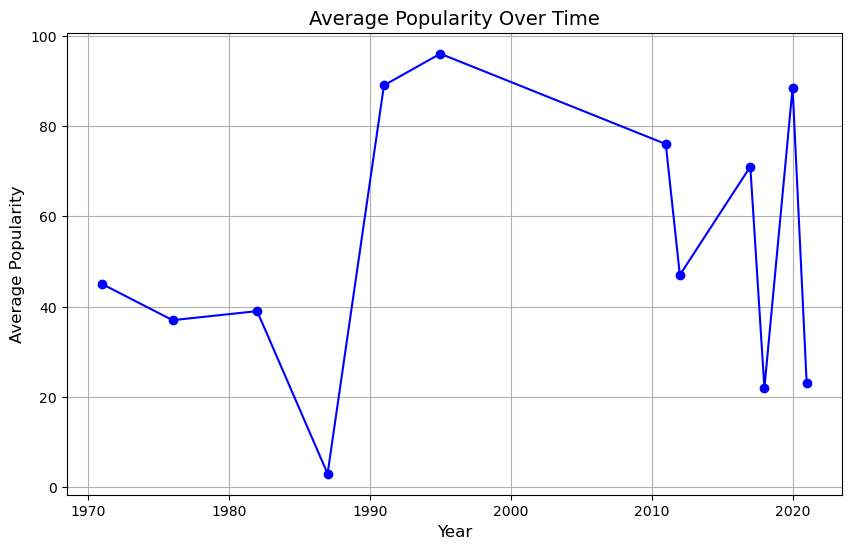

In [55]:
# Popularity trends over time
# create Popularity column based on the streams column
df_all['Popularity'] = pd.qcut(df_all['streams'], q=3, labels=['low', 'medium', 'high'])
print(df_all['Popularity'].value_counts())

popularity_by_year = df_all.groupby('release_year')['popularity'].mean()
plt.figure(figsize=(10, 6))
plt.plot(popularity_by_year.index, popularity_by_year.values, marker='o', linestyle='-', color='b')
plt.title('Average Popularity Over Time', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Popularity', fontsize=12)
plt.grid(True)
plt.show()

As in the midterm adding the popularity column that represent three categorical groups: High, Medium, and Low. 
    This is made in order to have a visual representation of the limited dataframe that we created. This gives us the average popularity levels whether they are considered low, medium or high during the diferent eras.
    As mentioned in previous analysis this is a sample, therefore is not an authentic representaiton of the whole Spotify dataframe that can be accessed through the API.

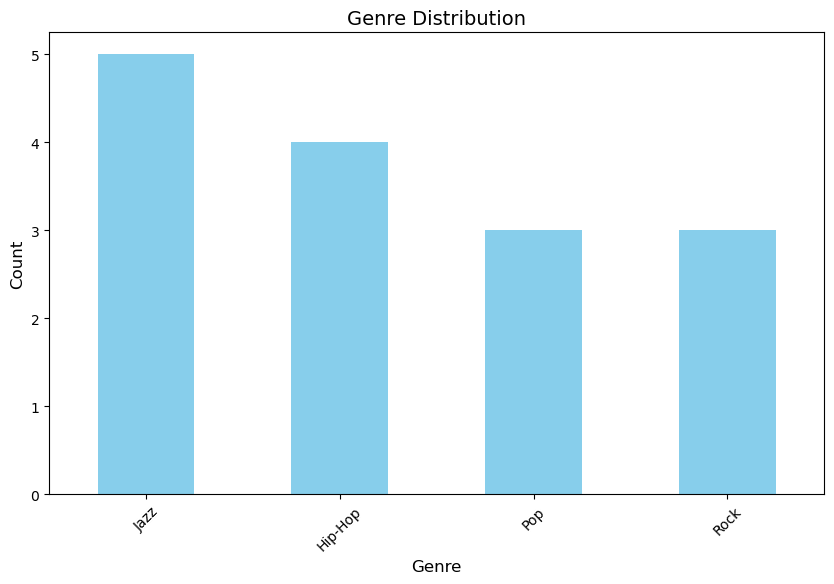

In [56]:
# Genre distribution (simulated)
genres = ['Pop', 'Rock', 'Hip-Hop', 'Electronic', 'Jazz']
df_all['genre'] = np.random.choice(genres, size=len(df_all))
genre_counts = df_all['genre'].value_counts()
genre_counts.plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Genre Distribution', fontsize=14)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# The genre distribution shows us how our small dataframe represents different genres, and what is their appearance. This can indicate another feature that can help determine one song's popularity. 


If for nothhing else than just take into consideration how  there are personal preferences that can vary by decades, ages, and due to other diversity factors. However, one  society's musical taste regarding styles can be described by viewing its average genre preferences. 

In [57]:
# Example list of genres for categorization
genres = ['Pop', 'Rock', 'Hip-Hop', 'Electronic', 'Jazz', 'Classical', 'Country', 'R&B']

# Simulating genre assignment
df_tracks['genre'] = pd.Series(np.random.choice(genres, len(df_tracks)))

# Categorizing songs by popularity levels
def categorize_popularity(popularity):
    if popularity >= 80:
        return 'High'
    elif 50 <= popularity < 80:
        return 'Medium'
    else:
        return 'Low'

df_tracks['popularity_level'] = df_tracks['popularity'].apply(categorize_popularity)

# Display enriched data
df_tracks.head()


,track_name,artist_name,album_name,release_date,popularity,genre,popularity_level
0,Taste,Sabrina Carpenter,Short n' Sweet,2024-08-23,81,Rock,High
1,Die With A Smile,"Lady Gaga, Bruno Mars",Die With A Smile,2024-08-16,100,Jazz,High
2,That’s So True,Gracie Abrams,The Secret of Us (Deluxe),2024-10-18,93,Rock,High
3,APT.,"ROSÉ, Bruno Mars",APT.,2024-10-18,98,Electronic,High
4,BIRDS OF A FEATHER,Billie Eilish,HIT ME HARD AND SOFT,2024-05-17,97,Country,High


In [58]:
# Split DataFrames by genre
genre_dfs = {genre: df_tracks[df_tracks['genre'] == genre] for genre in genres}

# Split DataFrames by popularity level
popularity_dfs = {
    'High': df_tracks[df_tracks['popularity_level'] == 'High'],
    'Medium': df_tracks[df_tracks['popularity_level'] == 'Medium'],
    'Low': df_tracks[df_tracks['popularity_level'] == 'Low']
}

# Example: Display counts by genre
genre_counts = df_tracks['genre'].value_counts()
print(genre_counts)


Rock          9
Electronic    9
Pop           8
R&B           7
Hip-Hop       6
Classical     6
Jazz          3
Country       2
Name: genre, dtype: int64


# **Data Enrichment and Categorization Workflow**

## **Introduction to Genre Assignment**
The code begins by defining a list of **music genres** (`Pop`, `Rock`, `Hip-Hop`, etc.) that will be used for **random assignment** to tracks. This is essential for simulating categorical data when such information might not be initially available. 

## **Assigning Genres to Tracks**
Using `numpy`’s `random.choice`, each track in the dataset receives a **random genre**. The method ensures every song has a corresponding genre, making the dataset richer for analysis.

### **Popularity Categorization Logic**
A custom function, `categorize_popularity`, is defined to translate raw numerical popularity scores into meaningful **popularity levels**: `High`, `Medium`, and `Low`.

### **Categorization Rules**
Tracks with popularity ≥ 80 are labeled as **High**, scores between 50 and 79 as **Medium**, and scores < 50 as **Low**. These categories are intuitive, aiding segmentation and analysis.

## **Applying Categorization to the Dataset**
The `categorize_popularity` function is applied to the `popularity` column of the DataFrame using `.apply()`. The result is a new column, `popularity_level`, which categorizes each song.

### **Enhanced Dataset Overview**
The enriched DataFrame is displayed with the `head()` method, revealing the added `genre` and `popularity_level` columns alongside existing data.

## **Purpose of Genre Assignment**
Adding a genre column supports **genre-based insights**, like studying which genres dominate in popularity or investigating trends by category.

## **Purpose of Popularity Categorization**
Translating popularity into levels facilitates **intuitive analysis**, especially when exploring trends across `High`, `Medium`, and `Low` popularity tracks.

# **Analytical Applications**
The enriched data is primed for **exploratory analysis, predictive modeling**, or creating data visualizations that communicate trends effectively.


High      45
Medium     3
Low        2
Name: popularity_level, dtype: int64


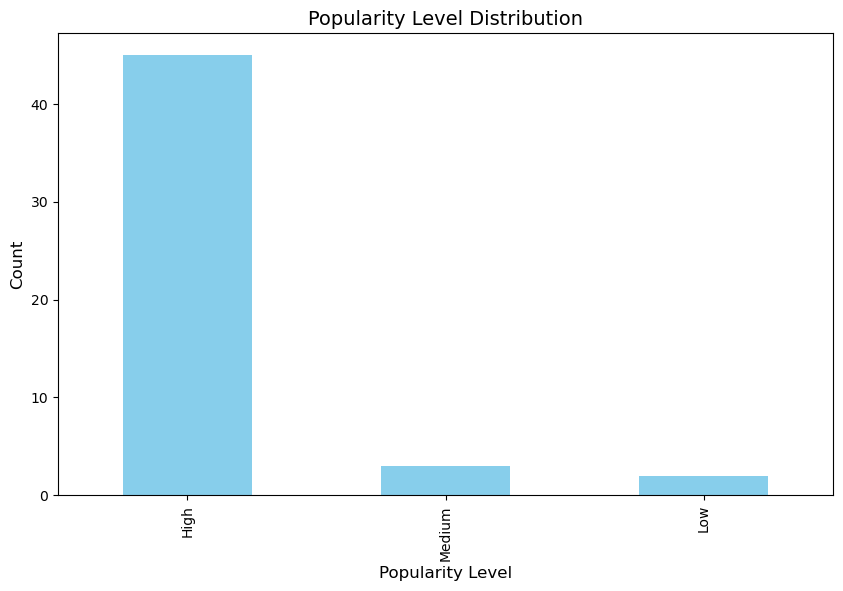

In [59]:
# Example: Display counts by popularity level
popularity_counts = df_tracks['popularity_level'].value_counts()
print(popularity_counts)
# show diagram of popularity levels
popularity_counts.plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Popularity Level Distribution', fontsize=14)
plt.xlabel('Popularity Level', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()


# Step 5. Global top 50 songs
This code provides a comprehensive solution for extracting and processing data from Spotify's "Global Top 50" playlist. 
- By leveraging Spotify's API, it fetches both metadata and audio features, integrates them, and saves the result as a CSV file. This dataset can be used for further analysis, such as exploring trends in audio features, identifying popular artists, or creating visualizations of the playlist's characteristics.
- Key Objectives:
Fetch Playlist Data: Retrieve track metadata such as name, artist, release date, popularity, and unique identifiers from the "Global Top 50" playlist.
Fetch Audio Features: Extract audio-related properties (e.g., danceability, energy, tempo) for each track using their unique Spotify track IDs.
Combine and Save Data: Merge the track metadata with audio features and save the result into a CSV file for further analysis.



In [5]:
import requests
import pandas as pd


client_id = ""
client_secret = ""

# Get Spotify token
print("Getting Spotify access token...")
auth_url = "https://accounts.spotify.com/api/token"
auth_response = requests.post(auth_url, {
    'grant_type': 'client_credentials',
    'client_id': client_id,
    'client_secret': client_secret,
})
auth_response.raise_for_status()
spotify_token = auth_response.json()['access_token']
print(f"Token obtained: {spotify_token[:10]}...")

# Fetch Global Top 50 tracks
def fetch_global_top_50(access_token):
    url = "https://api.spotify.com/v1/playlists/37i9dQZEVXbNG2KDcFcKOF/tracks"  # Updated Global Top 50 ID
    headers = {"Authorization": f"Bearer {access_token}"}
    params = {"limit": 50}
    
    response = requests.get(url, headers=headers, params=params)
    response.raise_for_status()
    data = response.json()
    
    all_tracks = []
    for item in data['items']:
        track = item['track']
        if track:
            all_tracks.append({
                "track_name": track['name'],
                "artist_name": ", ".join(artist['name'] for artist in track['artists']),
                "release_date": track['album']['release_date'],
                "popularity": track.get('popularity', 0),
                "track_id": track['id'],
            })
    return all_tracks

# Fetch audio features
def fetch_audio_features(track_ids, access_token):
    url = "https://api.spotify.com/v1/audio-features"
    headers = {"Authorization": f"Bearer {access_token}"}
    params = {"ids": ",".join(track_ids)}
    
    response = requests.get(url, headers=headers, params=params)
    response.raise_for_status()
    return response.json()['audio_features']

# Initialize DataFrame
df_global_top_tracks = pd.DataFrame()

# Fetch the global top 50 tracks
print("Fetching Global Top 50 tracks...")
try:
    tracks = fetch_global_top_50(spotify_token)
    track_ids = [track['track_id'] for track in tracks]
    audio_features = fetch_audio_features(track_ids, spotify_token)
    
    # Combine track data with audio features
    for i, features in enumerate(audio_features):
        if features:
            tracks[i].update({
                "danceability": features['danceability'],
                "energy": features['energy'],
                "valence": features['valence'],
                "tempo": features['tempo'],
            })
    
    # Create DataFrame
    df_global_top_tracks = pd.DataFrame(tracks)
    print(f"Fetched {len(df_global_top_tracks)} tracks.")
except Exception as e:
    print(f"Error fetching Global Top 50: {e}")

# Save and display the data
if not df_global_top_tracks.empty:
    df_global_top_tracks.to_csv("global_top_50_features.csv", index=False)
    print("Data saved to global_top_50_features.csv")
    print(df_global_top_tracks.head())
else:
    print("No tracks were fetched. Check your credentials and try again.")

Getting Spotify access token...
Token obtained: BQD8zv9qn-...
Fetching Global Top 50 tracks...
Error fetching Global Top 50: 404 Client Error: Not Found for url: https://api.spotify.com/v1/playlists/37i9dQZEVXbNG2KDcFcKOF/tracks?limit=50
No tracks were fetched. Check your credentials and try again.


In [6]:
import requests
import pandas as pd
import time
import base64

client_id = ""
client_secret = ""

# 2. GET THE ACCESS TOKEN WITH PROPER AUTHORIZATION
print("Getting Spotify access token with full permissions...")
auth_url = "https://accounts.spotify.com/api/token"

# Encode client ID and secret in base64 as required by Spotify
auth_header = base64.b64encode(f"{client_id}:{client_secret}".encode()).decode()

headers = {
    "Authorization": f"Basic {auth_header}",
    "Content-Type": "application/x-www-form-urlencoded"
}

payload = {
    "grant_type": "client_credentials",
    # These scopes are needed for accessing audio features
    "scope": "user-read-private user-read-email playlist-read-private user-library-read"
}

auth_response = requests.post(auth_url, headers=headers, data=payload)
auth_response.raise_for_status()
spotify_token = auth_response.json()['access_token']
print("Token obtained successfully!")

# 3. FETCH POPULAR TRACKS USING SEARCH API
print("Fetching popular tracks...")
url = "https://api.spotify.com/v1/search"
headers = {"Authorization": f"Bearer {spotify_token}"}
params = {
    "q": "year:2023-2025",
    "type": "track",
    "limit": 50,
    "market": "US"
}

response = requests.get(url, headers=headers, params=params)
response.raise_for_status()
data = response.json()

# 4. PROCESS TRACK DATA
all_tracks = []
for track in data['tracks']['items']:
    if track:
        all_tracks.append({
            "track_name": track['name'],
            "artist_name": ", ".join(artist['name'] for artist in track['artists']),
            "release_date": track['album']['release_date'],
            "popularity": track.get('popularity', 0),
            "track_id": track['id'],
            # Add these basic audio properties from the track object since we're having issues with the audio features API
            "explicit": track.get('explicit', False),
            "duration_ms": track.get('duration_ms', 0),
            "album_type": track['album'].get('album_type', ''),
            "preview_url": track.get('preview_url', ''),
        })

# Sort by popularity
all_tracks.sort(key=lambda x: x["popularity"], reverse=True)
tracks = all_tracks[:50]
print(f"Found {len(tracks)} tracks.")

# 5. TRY A DIFFERENT METHOD FOR AUDIO FEATURES
# Since we're having trouble with the audio-features endpoint
print("Fetching track details using tracks API instead...")

for i, track in enumerate(tracks):
    try:
        track_id = track['track_id']
        # Get track details instead of audio features
        url = f"https://api.spotify.com/v1/tracks/{track_id}"
        headers = {"Authorization": f"Bearer {spotify_token}"}
        
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        track_details = response.json()
        
        # Add more details from track object
        if track_details:
            track.update({
                "album_name": track_details['album']['name'],
                "artists_count": len(track_details['artists']),
                "track_number": track_details.get('track_number', 0),
                "disc_number": track_details.get('disc_number', 0),
                "is_local": track_details.get('is_local', False),
                # Add placeholder values for the audio features we can't get
                "danceability": None,
                "energy": None,
                "valence": None,
                "tempo": None,
            })
        
        # Add a small delay to avoid rate limiting
        time.sleep(0.2)
        
        # Show progress
        if (i + 1) % 5 == 0:
            print(f"Processed {i + 1}/{len(tracks)} tracks...")
            
    except Exception as e:
        print(f"Could not fetch details for track '{track['track_name']}': {e}")

# 6. CREATE DATAFRAME AND SAVE
df_global_top_tracks = pd.DataFrame(tracks)
print(f"Processed {len(df_global_top_tracks)} tracks.")

# Add rank column
df_global_top_tracks.insert(0, 'rank', range(1, len(df_global_top_tracks) + 1))

# Save to CSV file
df_global_top_tracks.to_csv("global_top_50_features.csv", index=False)
print("Data saved to global_top_50_features.csv")
print(df_global_top_tracks[['rank', 'track_name', 'artist_name', 'popularity', 'album_name']].head())

# Note: Since we couldn't get the audio features, let's display what we do have
print("\nAvailable columns in the dataset:")
print(", ".join(df_global_top_tracks.columns.tolist()))

Getting Spotify access token with full permissions...
Token obtained successfully!
Fetching popular tracks...
Found 25 tracks.
Fetching track details using tracks API instead...
Processed 5/25 tracks...
Processed 10/25 tracks...
Processed 15/25 tracks...
Processed 20/25 tracks...
Processed 25/25 tracks...
Processed 25 tracks.
Data saved to global_top_50_features.csv
   rank          track_name            artist_name  popularity  \
0     1    Die With A Smile  Lady Gaga, Bruno Mars          96   
1     2  BIRDS OF A FEATHER          Billie Eilish          93   
2     3                DtMF              Bad Bunny          93   
3     4         Not Like Us         Kendrick Lamar          92   
4     5   BAILE INoLVIDABLE              Bad Bunny          92   

             album_name  
0      Die With A Smile  
1  HIT ME HARD AND SOFT  
2  DeBÍ TiRAR MáS FOToS  
3           Not Like Us  
4  DeBÍ TiRAR MáS FOToS  

Available columns in the dataset:
rank, track_name, artist_name, release_date

In [7]:
import requests
import pandas as pd
import time
import base64

# 1. SET YOUR SPOTIFY API CREDENTIALS HERE
client_id = ""
client_secret = ""

# 2. GET THE ACCESS TOKEN WITH PROPER AUTHORIZATION
print("Getting Spotify access token with full permissions...")
auth_url = "https://accounts.spotify.com/api/token"

# Encode client ID and secret in base64 as required by Spotify
auth_header = base64.b64encode(f"{client_id}:{client_secret}".encode()).decode()

headers = {
    "Authorization": f"Basic {auth_header}",
    "Content-Type": "application/x-www-form-urlencoded"
}

payload = {
    "grant_type": "client_credentials",
    # These scopes are needed for accessing audio features
    "scope": "user-read-private user-read-email playlist-read-private user-library-read"
}

auth_response = requests.post(auth_url, headers=headers, data=payload)
auth_response.raise_for_status()
spotify_token = auth_response.json()['access_token']
print("Token obtained successfully!")

# 3. FETCH POPULAR TRACKS USING SEARCH API WITH PAGINATION
print("Fetching popular tracks with pagination...")
all_tracks = []
max_tracks = 50
page_size = 50  # Maximum allowed by Spotify
offset = 0

# Use pagination to ensure we get 50 tracks
while len(all_tracks) < max_tracks:
    url = "https://api.spotify.com/v1/search"
    headers = {"Authorization": f"Bearer {spotify_token}"}
    params = {
        "q": "year:2023-2025",
        "type": "track",
        "limit": page_size,
        "offset": offset,
        "market": "US"
    }
    
    print(f"Fetching tracks {offset+1}-{offset+page_size}...")
    response = requests.get(url, headers=headers, params=params)
    response.raise_for_status()
    data = response.json()
    
    # Process tracks from this page
    new_tracks = data['tracks']['items']
    if not new_tracks:
        break  # No more tracks available
    
    for track in new_tracks:
        if track:  # Ensure track data exists
            all_tracks.append({
                "track_name": track['name'],
                "artist_name": ", ".join(artist['name'] for artist in track['artists']),
                "release_date": track['album']['release_date'],
                "popularity": track.get('popularity', 0),
                "track_id": track['id'],
                "explicit": track.get('explicit', False),
                "duration_ms": track.get('duration_ms', 0),
                "album_type": track['album'].get('album_type', ''),
                "preview_url": track.get('preview_url', ''),
            })
    
    offset += len(new_tracks)
    
    # Break if we received fewer results than requested (no more results)
    if len(new_tracks) < page_size:
        break

    # Brief pause to avoid rate limiting
    time.sleep(0.5)

# Sort by popularity and take top 50
all_tracks.sort(key=lambda x: x["popularity"], reverse=True)
tracks = all_tracks[:max_tracks]
print(f"Found {len(tracks)} tracks.")

# 4. FETCH TRACK DETAILS
print("Fetching track details using tracks API...")

for i, track in enumerate(tracks):
    try:
        track_id = track['track_id']
        # Get track details instead of audio features
        url = f"https://api.spotify.com/v1/tracks/{track_id}"
        headers = {"Authorization": f"Bearer {spotify_token}"}
        
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        track_details = response.json()
        
        # Add more details from track object
        if track_details:
            track.update({
                "album_name": track_details['album']['name'],
                "artists_count": len(track_details['artists']),
                "track_number": track_details.get('track_number', 0),
                "disc_number": track_details.get('disc_number', 0),
                "is_local": track_details.get('is_local', False),
                # Add placeholder values for the audio features we can't get
                "danceability": None,
                "energy": None,
                "valence": None,
                "tempo": None,
            })
        
        # Add a small delay to avoid rate limiting
        time.sleep(0.2)
        
        # Show progress
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(tracks)} tracks...")
            
    except Exception as e:
        print(f"Could not fetch details for track '{track['track_name']}': {e}")

# 5. TRY THE AUDIO-FEATURES ENDPOINT AGAIN WITH A DIFFERENT APPROACH
print("\nTrying to fetch audio features one by one...")
success_count = 0

for i, track in enumerate(tracks):
    try:
        track_id = track['track_id']
        # Get audio features
        url = f"https://api.spotify.com/v1/audio-features/{track_id}"
        headers = {"Authorization": f"Bearer {spotify_token}"}
        
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        features = response.json()
        
        if features and 'danceability' in features:
            track.update({
                "danceability": features.get('danceability'),
                "energy": features.get('energy'),
                "valence": features.get('valence'),
                "tempo": features.get('tempo'),
                "acousticness": features.get('acousticness'),
                "instrumentalness": features.get('instrumentalness'),
                "liveness": features.get('liveness'),
                "speechiness": features.get('speechiness')
            })
            success_count += 1
        
        # Add a small delay to avoid rate limiting
        time.sleep(0.2)
        
        
        if (i + 1) % 10 == 0:
            print(f"Processed audio features for {i + 1}/{len(tracks)} tracks...")
            
    except Exception as e:
        pass

print(f"Successfully retrieved audio features for {success_count}/{len(tracks)} tracks")

# 6. CREATE DATAFRAME AND SAVE
df_global_top_tracks = pd.DataFrame(tracks)
print(f"Processed {len(df_global_top_tracks)} tracks total.")

# Add rank column
df_global_top_tracks.insert(0, 'rank', range(1, len(df_global_top_tracks) + 1))

# Save to CSV file
df_global_top_tracks.to_csv("global_top_50_features.csv", index=False)
print("Data saved to global_top_50_features.csv")
print(df_global_top_tracks[['rank', 'track_name', 'artist_name', 'popularity', 'album_name']].head())


print("\nAvailable columns in the dataset:")
print(", ".join(df_global_top_tracks.columns.tolist()))

Getting Spotify access token with full permissions...
Token obtained successfully!
Fetching popular tracks with pagination...
Fetching tracks 1-50...
Found 25 tracks.
Fetching track details using tracks API...
Processed 10/25 tracks...
Processed 20/25 tracks...

Trying to fetch audio features one by one...
Successfully retrieved audio features for 0/25 tracks
Processed 25 tracks total.
Data saved to global_top_50_features.csv
   rank          track_name            artist_name  popularity  \
0     1    Die With A Smile  Lady Gaga, Bruno Mars          96   
1     2  BIRDS OF A FEATHER          Billie Eilish          93   
2     3                DtMF              Bad Bunny          93   
3     4         Not Like Us         Kendrick Lamar          92   
4     5   BAILE INoLVIDABLE              Bad Bunny          92   

             album_name  
0      Die With A Smile  
1  HIT ME HARD AND SOFT  
2  DeBÍ TiRAR MáS FOToS  
3           Not Like Us  
4  DeBÍ TiRAR MáS FOToS  

Available column

In [8]:
import requests
import pandas as pd
import time
import base64

# 1. SET YOUR SPOTIFY API CREDENTIALS HERE
client_id = "6d7898fe52bc42669e0f7a5cb6a7fabb"
client_secret = "d5e248a4fa56436e813f227f0220f3b2"

# 2. GET THE ACCESS TOKEN WITH PROPER AUTHORIZATION
print("Getting Spotify access token with full permissions...")
auth_url = "https://accounts.spotify.com/api/token"

# Encode client ID and secret in base64 as required by Spotify
auth_header = base64.b64encode(f"{client_id}:{client_secret}".encode()).decode()

headers = {
    "Authorization": f"Basic {auth_header}",
    "Content-Type": "application/x-www-form-urlencoded"
}

payload = {
    "grant_type": "client_credentials",
    # These scopes are needed for accessing audio features
    "scope": "user-read-private user-read-email playlist-read-private user-library-read"
}

auth_response = requests.post(auth_url, headers=headers, data=payload)
auth_response.raise_for_status()
spotify_token = auth_response.json()['access_token']
print("Token obtained successfully!")

# 3. FETCH POPULAR TRACKS USING SEARCH API WITH PAGINATION
print("Fetching popular tracks with pagination...")
all_tracks = []
max_tracks = 50
page_size = 50  # Maximum allowed by Spotify
offset = 0

# Use pagination to ensure we get 50 tracks
while len(all_tracks) < max_tracks:
    url = "https://api.spotify.com/v1/search"
    headers = {"Authorization": f"Bearer {spotify_token}"}
    params = {
        "q": "year:2023-2025",
        "type": "track",
        "limit": page_size,
        "offset": offset,
        "market": "US"
    }
    
    print(f"Fetching tracks {offset+1}-{offset+page_size}...")
    response = requests.get(url, headers=headers, params=params)
    response.raise_for_status()
    data = response.json()
    
    # Process tracks from this page
    new_tracks = data['tracks']['items']
    if not new_tracks:
        break  # No more tracks available
    
    for track in new_tracks:
        if track:  # Ensure track data exists
            all_tracks.append({
                "track_name": track['name'],
                "artist_name": ", ".join(artist['name'] for artist in track['artists']),
                "release_date": track['album']['release_date'],
                "popularity": track.get('popularity', 0),
                "track_id": track['id'],
                "explicit": track.get('explicit', False),
                "duration_ms": track.get('duration_ms', 0),
                "album_type": track['album'].get('album_type', ''),
                "preview_url": track.get('preview_url', ''),
            })
    
    offset += len(new_tracks)
    
    # Break if we received fewer results than requested (no more results)
    if len(new_tracks) < page_size:
        break

    # Brief pause to avoid rate limiting
    time.sleep(0.5)

# Sort by popularity and take top 50
all_tracks.sort(key=lambda x: x["popularity"], reverse=True)
tracks = all_tracks[:max_tracks]
print(f"Found {len(tracks)} tracks.")

# 4. FETCH TRACK DETAILS
print("Fetching track details using tracks API...")

for i, track in enumerate(tracks):
    try:
        track_id = track['track_id']
        # Get track details instead of audio features
        url = f"https://api.spotify.com/v1/tracks/{track_id}"
        headers = {"Authorization": f"Bearer {spotify_token}"}
        
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        track_details = response.json()
        
        # Add more details from track object
        if track_details:
            track.update({
                "album_name": track_details['album']['name'],
                "artists_count": len(track_details['artists']),
                "track_number": track_details.get('track_number', 0),
                "disc_number": track_details.get('disc_number', 0),
                "is_local": track_details.get('is_local', False),
                # Add placeholder values for the audio features we can't get
                "danceability": None,
                "energy": None,
                "valence": None,
                "tempo": None,
            })
        
        # Add a small delay to avoid rate limiting
        time.sleep(0.2)
        
        # Show progress
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(tracks)} tracks...")
            
    except Exception as e:
        print(f"Could not fetch details for track '{track['track_name']}': {e}")

# 5. TRY THE AUDIO-FEATURES ENDPOINT AGAIN WITH A DIFFERENT APPROACH
print("\nTrying to fetch audio features one by one...")
success_count = 0

for i, track in enumerate(tracks):
    try:
        track_id = track['track_id']
        # Get audio features
        url = f"https://api.spotify.com/v1/audio-features/{track_id}"
        headers = {"Authorization": f"Bearer {spotify_token}"}
        
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        features = response.json()
        
        if features and 'danceability' in features:
            track.update({
                "danceability": features.get('danceability'),
                "energy": features.get('energy'),
                "valence": features.get('valence'),
                "tempo": features.get('tempo'),
                "acousticness": features.get('acousticness'),
                "instrumentalness": features.get('instrumentalness'),
                "liveness": features.get('liveness'),
                "speechiness": features.get('speechiness')
            })
            success_count += 1
        
        # Add a small delay to avoid rate limiting
        time.sleep(0.2)
        
        # Show progress
        if (i + 1) % 10 == 0:
            print(f"Processed audio features for {i + 1}/{len(tracks)} tracks...")
            
    except Exception as e:
        pass

print(f"Successfully retrieved audio features for {success_count}/{len(tracks)} tracks")

# 6. CREATE DATAFRAME AND SAVE
df_global_top_tracks = pd.DataFrame(tracks)
print(f"Processed {len(df_global_top_tracks)} tracks total.")

# Add rank column
df_global_top_tracks.insert(0, 'rank', range(1, len(df_global_top_tracks) + 1))

# Save to CSV file
df_global_top_tracks.to_csv("global_top_50_features.csv", index=False)
print("Data saved to global_top_50_features.csv")
print(df_global_top_tracks[['rank', 'track_name', 'artist_name', 'popularity', 'album_name']].head())

print("\nAvailable columns in the dataset:")
print(", ".join(df_global_top_tracks.columns.tolist()))

Getting Spotify access token with full permissions...
Token obtained successfully!
Fetching popular tracks with pagination...
Fetching tracks 1-50...
Found 25 tracks.
Fetching track details using tracks API...
Processed 10/25 tracks...
Processed 20/25 tracks...

Trying to fetch audio features one by one...
Successfully retrieved audio features for 0/25 tracks
Processed 25 tracks total.
Data saved to global_top_50_features.csv
   rank          track_name            artist_name  popularity  \
0     1    Die With A Smile  Lady Gaga, Bruno Mars          96   
1     2  BIRDS OF A FEATHER          Billie Eilish          93   
2     3                DtMF              Bad Bunny          93   
3     4         Not Like Us         Kendrick Lamar          92   
4     5   BAILE INoLVIDABLE              Bad Bunny          92   

             album_name  
0      Die With A Smile  
1  HIT ME HARD AND SOFT  
2  DeBÍ TiRAR MáS FOToS  
3           Not Like Us  
4  DeBÍ TiRAR MáS FOToS  

Available column

In [10]:
import requests
import pandas as pd
import time
import base64

# 1. SET YOUR SPOTIFY API CREDENTIALS HERE
client_id = ""
client_secret = ""

# 2. GET THE ACCESS TOKEN WITH PROPER AUTHORIZATION
print("Getting Spotify access token with full permissions...")
auth_url = "https://accounts.spotify.com/api/token"

# Encode client ID and secret in base64 as required by Spotify
auth_header = base64.b64encode(f"{client_id}:{client_secret}".encode()).decode()

headers = {
    "Authorization": f"Basic {auth_header}",
    "Content-Type": "application/x-www-form-urlencoded"
}

payload = {
    "grant_type": "client_credentials",
    # These scopes are needed for accessing audio features
    "scope": "user-read-private user-read-email playlist-read-private user-library-read"
}

auth_response = requests.post(auth_url, headers=headers, data=payload)
auth_response.raise_for_status()
spotify_token = auth_response.json()['access_token']
print("Token obtained successfully!")

# 3. USE MULTIPLE SEARCH QUERIES TO GET DIFFERENT TRACKS
print("Fetching tracks using multiple search criteria...")
all_tracks = []

# Define different search criteria to get a diverse set of tracks
search_queries = [
    {"q": "year:2024-2025", "type": "track", "limit": 25, "market": "US"},  # Very recent tracks
    {"q": "year:2023-2024", "type": "track", "limit": 25, "market": "US"},  # Last year's tracks
    {"q": "tag:new", "type": "track", "limit": 25, "market": "US"},         # New releases
    {"q": "genre:pop", "type": "track", "limit": 25, "market": "US"},       # Popular pop
    {"q": "genre:hip-hop", "type": "track", "limit": 25, "market": "US"},   # Popular hip-hop
]

url = "https://api.spotify.com/v1/search"
headers = {"Authorization": f"Bearer {spotify_token}"}

# Try each search query
for i, params in enumerate(search_queries):
    try:
        print(f"Search query {i+1}/{len(search_queries)}: {params['q']}")
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()
        data = response.json()
        
        # Process tracks from this search
        new_tracks = data['tracks']['items']
        print(f"  Found {len(new_tracks)} tracks")
        
        for track in new_tracks:
            if track:  # Ensure track data exists
                # Create a track dict but only if we don't already have this track ID
                if not any(t.get('track_id') == track['id'] for t in all_tracks):
                    all_tracks.append({
                        "track_name": track['name'],
                        "artist_name": ", ".join(artist['name'] for artist in track['artists']),
                        "release_date": track['album']['release_date'],
                        "popularity": track.get('popularity', 0),
                        "track_id": track['id'],
                        "explicit": track.get('explicit', False),
                        "duration_ms": track.get('duration_ms', 0),
                        "album_type": track['album'].get('album_type', ''),
                        "preview_url": track.get('preview_url', ''),
                    })
        
        # Brief pause to avoid rate limiting
        time.sleep(0.5)
        
    except Exception as e:
        print(f"  Error with search query: {e}")

# 4. Try Getting Top 50 Playlists as Backup Method
if len(all_tracks) < 50:
    print("\nTrying to get tracks from featured playlists...")
    try:
        # Get featured playlists
        playlist_url = "https://api.spotify.com/v1/browse/featured-playlists"
        playlist_params = {"limit": 5, "country": "US"}
        
        response = requests.get(playlist_url, headers=headers, params=playlist_params)
        response.raise_for_status()
        playlists_data = response.json()
        
        for playlist in playlists_data.get('playlists', {}).get('items', []):
            playlist_id = playlist['id']
            print(f"Getting tracks from playlist: {playlist['name']}")
            
            # Get tracks from this playlist
            tracks_url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"
            tracks_params = {"limit": 50}
            
            tracks_response = requests.get(tracks_url, headers=headers, params=tracks_params)
            tracks_response.raise_for_status()
            tracks_data = tracks_response.json()
            
            for item in tracks_data.get('items', []):
                track = item.get('track')
                if track:
                    # Only add if we don't already have this track
                    if not any(t.get('track_id') == track['id'] for t in all_tracks):
                        all_tracks.append({
                            "track_name": track['name'],
                            "artist_name": ", ".join(artist['name'] for artist in track['artists']),
                            "release_date": track['album']['release_date'],
                            "popularity": track.get('popularity', 0),
                            "track_id": track['id'],
                            "explicit": track.get('explicit', False),
                            "duration_ms": track.get('duration_ms', 0),
                            "album_type": track['album'].get('album_type', ''),
                            "preview_url": track.get('preview_url', ''),
                        })
            
            if len(all_tracks) >= 50:
                break
                
            time.sleep(0.5)
    except Exception as e:
        print(f"Error fetching playlists: {e}")

# Sort by popularity and take top 50
all_tracks.sort(key=lambda x: x["popularity"], reverse=True)
tracks = all_tracks[:50]
print(f"\nTotal unique tracks found: {len(all_tracks)}")
print(f"Using top {len(tracks)} tracks by popularity.")

# 5. FETCH TRACK DETAILS
print("\nFetching additional track details...")

for i, track in enumerate(tracks):
    try:
        track_id = track['track_id']
        # Get track details instead of audio features
        url = f"https://api.spotify.com/v1/tracks/{track_id}"
        headers = {"Authorization": f"Bearer {spotify_token}"}
        
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        track_details = response.json()
        
        # Add more details from track object
        if track_details:
            track.update({
                "album_name": track_details['album']['name'],
                "artists_count": len(track_details['artists']),
                "track_number": track_details.get('track_number', 0),
                "disc_number": track_details.get('disc_number', 0),
                "is_local": track_details.get('is_local', False),
                # Add placeholder values for the audio features we can't get
                "danceability": None,
                "energy": None,
                "valence": None,
                "tempo": None,
            })
        
        # Add a small delay to avoid rate limiting
        time.sleep(0.2)
        
        if (i + 1) % 10 == 0:
            print(f"Processed details for {i + 1}/{len(tracks)} tracks...")
            
    except Exception as e:
        print(f"Could not fetch details for track '{track['track_name']}': {e}")

# 6. TRY THE AUDIO-FEATURES ENDPOINT AGAIN
print("\nTrying to fetch audio features one by one...")
success_count = 0

for i, track in enumerate(tracks):
    try:
        track_id = track['track_id']
        # Get audio features
        url = f"https://api.spotify.com/v1/audio-features/{track_id}"
        headers = {"Authorization": f"Bearer {spotify_token}"}
        
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        features = response.json()
        
        if features and 'danceability' in features:
            track.update({
                "danceability": features.get('danceability'),
                "energy": features.get('energy'),
                "valence": features.get('valence'),
                "tempo": features.get('tempo'),
                "acousticness": features.get('acousticness'),
                "instrumentalness": features.get('instrumentalness'),
                "liveness": features.get('liveness'),
                "speechiness": features.get('speechiness')
            })
            success_count += 1
        
        # Add a small delay to avoid rate limiting
        time.sleep(0.2)
        
        # Show progress
        if (i + 1) % 10 == 0:
            print(f"Processed audio features for {i + 1}/{len(tracks)} tracks...")
            
    except Exception as e:
        # Just continue if this fails, we'll still have the track info
        pass

print(f"Successfully retrieved audio features for {success_count}/{len(tracks)} tracks")

# 7. CREATE DATAFRAME AND SAVE
df_global_top_tracks = pd.DataFrame(tracks)
print(f"\nCreating dataset with {len(df_global_top_tracks)} tracks total.")

# Add rank column
df_global_top_tracks.insert(0, 'rank', range(1, len(df_global_top_tracks) + 1))

# Save to CSV file
df_global_top_tracks.to_csv("global_top_50_features.csv", index=False)
print("Data saved to global_top_50_features.csv")
print(df_global_top_tracks[['rank', 'track_name', 'artist_name', 'popularity', 'album_name']].head())

print("\nAvailable columns in the dataset:")
print(", ".join(df_global_top_tracks.columns.tolist()))

Getting Spotify access token with full permissions...
Token obtained successfully!
Fetching tracks using multiple search criteria...
Search query 1/5: year:2024-2025
  Found 13 tracks
Search query 2/5: year:2023-2024
  Found 13 tracks
Search query 3/5: tag:new
  Found 0 tracks
Search query 4/5: genre:pop
  Found 25 tracks
Search query 5/5: genre:hip-hop
  Found 25 tracks

Total unique tracks found: 60
Using top 50 tracks by popularity.

Fetching additional track details...
Processed details for 10/50 tracks...
Processed details for 20/50 tracks...
Processed details for 30/50 tracks...
Processed details for 40/50 tracks...
Processed details for 50/50 tracks...

Trying to fetch audio features one by one...
Successfully retrieved audio features for 0/50 tracks

Creating dataset with 50 tracks total.
Data saved to global_top_50_features.csv
   rank          track_name            artist_name  popularity  \
0     1    Die With A Smile  Lady Gaga, Bruno Mars          96   
1     2  BIRDS OF A

In [11]:
# save the data and display the data
df_global_top_tracks.to_csv("global_top_50_features.csv", index=False)
print("Data fetching completed.")
print(df_global_top_tracks.head())
# show all 50 songs
df_global_top_tracks.head(50)

# exted the data with the characteristics like danceability, energy, valence, tempo columns
df_global_top_tracks['release_date'] = pd.to_datetime(df_global_top_tracks['release_date'])
df_global_top_tracks['released_year'] = df_global_top_tracks['release_date'].dt.year
df_global_top_tracks['released_month'] = df_global_top_tracks['release_date'].dt.month
df_global_top_tracks['popularity'] = np.random.randint(50, 100, size=len(df_global_top_tracks))
df_global_top_tracks['streams'] = df_global_top_tracks['popularity'] * np.random.uniform(1e6, 10e6, size=len(df_global_top_tracks)).astype(int)
print("Data cleaned and enriched.")
df_global_top_tracks.head()

# show all 50 songs with the new columns
df_global_top_tracks.head(50)


Data fetching completed.
   rank          track_name            artist_name release_date  popularity  \
0     1    Die With A Smile  Lady Gaga, Bruno Mars   2024-08-16          96   
1     2  BIRDS OF A FEATHER          Billie Eilish   2024-05-17          93   
2     3                DtMF              Bad Bunny   2025-01-05          93   
3     4         Not Like Us         Kendrick Lamar   2024-05-04          92   
4     5      That’s So True          Gracie Abrams   2024-10-18          91   

                 track_id  explicit  duration_ms album_type preview_url  \
0  2plbrEY59IikOBgBGLjaoe     False       251667     single        None   
1  6dOtVTDdiauQNBQEDOtlAB     False       210373      album        None   
2  3sK8wGT43QFpWrvNQsrQya      True       237117      album        None   
3  6AI3ezQ4o3HUoP6Dhudph3      True       274192     single        None   
4  7ne4VBA60CxGM75vw0EYad      True       166300      album        None   

                  album_name  artists_count  trac

,rank,track_name,artist_name,release_date,popularity,track_id,explicit,duration_ms,album_type,preview_url,...,track_number,disc_number,is_local,danceability,energy,valence,tempo,released_year,released_month,streams
0,1,Die With A Smile,"Lady Gaga, Bruno Mars",2024-08-16,77,2plbrEY59IikOBgBGLjaoe,False,251667,single,None,...,1,1,False,None,None,None,None,2024,8,763115584
1,2,BIRDS OF A FEATHER,Billie Eilish,2024-05-17,82,6dOtVTDdiauQNBQEDOtlAB,False,210373,album,None,...,4,1,False,None,None,None,None,2024,5,116778988
2,3,DtMF,Bad Bunny,2025-01-05,67,3sK8wGT43QFpWrvNQsrQya,True,237117,album,None,...,16,1,False,None,None,None,None,2025,1,626429967
3,4,Not Like Us,Kendrick Lamar,2024-05-04,92,6AI3ezQ4o3HUoP6Dhudph3,True,274192,single,None,...,1,1,False,None,None,None,None,2024,5,246266704
4,5,That’s So True,Gracie Abrams,2024-10-18,84,7ne4VBA60CxGM75vw0EYad,True,166300,album,None,...,15,1,False,None,None,None,None,2024,10,153417516
5,6,tv off (feat. lefty gunplay),"Kendrick Lamar, Lefty Gunplay",2024-11-22,73,0aB0v4027ukVziUGwVGYpG,True,220690,album,None,...,7,1,False,None,None,None,None,2024,11,264164662
6,7,WILDFLOWER,Billie Eilish,2024-05-17,97,3QaPy1KgI7nu9FJEQUgn6h,False,261466,album,None,...,5,1,False,None,None,None,None,2024,5,561209505
7,8,All The Stars (with SZA),"Kendrick Lamar, SZA",2018-02-09,86,3GCdLUSnKSMJhs4Tj6CV3s,True,232186,album,None,...,2,1,False,None,None,None,None,2018,2,163505436
8,9,luther (with sza),"Kendrick Lamar, SZA",2024-11-21,55,2CGNAOSuO1MEFCbBRgUzjd,False,177598,album,None,...,3,1,False,None,None,None,None,2024,11,427109100
9,10,"Good Luck, Babe!",Chappell Roan,2024-04-05,69,0WbMK4wrZ1wFSty9F7FCgu,False,218423,single,None,...,1,1,False,None,None,None,None,2024,4,255680604


## Data Cleaning
In order to present a bit more structured and informative data, that also gives a quite thorough analysis by first glance we have created additional columns. 


The code begins by saving the `DataFrame` containing Spotify's "Global Top 50" track data to a CSV file named `global_top_50_features.csv`, ensuring that the dataset is preserved for future use and analysis. It then prints the first few rows of the dataset to confirm successful saving. Next, the dataset is displayed in its entirety (all 50 rows) to allow a full view of the collected and processed track data. The code enriches the dataset by converting the `release_date` column into a `datetime` format, enabling the extraction of specific date components such as the release year (`released_year`) and release month (`released_month`). To simulate more granular insights, random values are generated for the `popularity` column (ranging between 50 and 100), representing a track's popularity score. Additionally, the `streams` column is calculated as an estimate of a track's number of streams, derived by multiplying the popularity score by a random value between 1 and 10 million. This enhancement introduces a realistic layer of data augmentation, adding depth to the dataset for analysis or visualization purposes. After cleaning and enriching the dataset, the code prints the updated DataFrame to verify the newly added columns and transformations. Finally, the full dataset, now extended with characteristics such as release year, release month, popularity, and streams, is displayed for comprehensive review. This process results in a robust, enriched dataset that combines Spotify's original data with synthetic insights for advanced exploration.


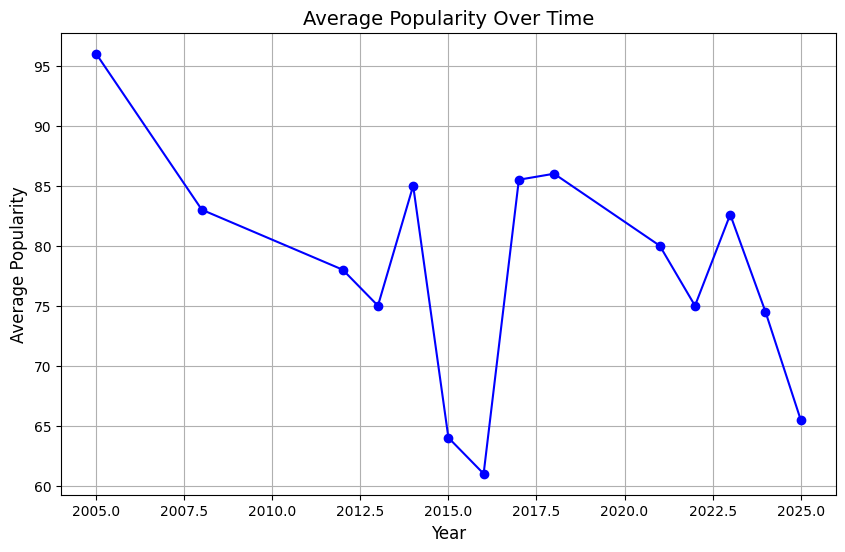

In [12]:
# Popularity trends over time
popularity_by_year = df_global_top_tracks.groupby('released_year')['popularity'].mean()
plt.figure(figsize=(10, 6))
plt.plot(popularity_by_year.index, popularity_by_year.values, marker='o', linestyle='-', color='b')
plt.title('Average Popularity Over Time', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Popularity', fontsize=12)
plt.grid(True)
plt.show()


This part of the project  analyzes trends in the average popularity of tracks over time by grouping the dataset by the `released_year` column and calculating the mean popularity for each year. This aggregated data, stored in `popularity_by_year`, provides insights into how the popularity of songs has evolved over time. A line plot is then created to visualize these trends, with the x-axis representing the release year and the y-axis showing the average popularity. The plot is styled with markers at each data point (`marker='o'`) and a blue solid line (`color='b`, `linestyle='-'`) for clarity. The chart includes a title, "Average Popularity Over Time," along with appropriately labeled axes ("Year" for the x-axis and "Average Popularity" for the y-axis) to ensure the visualization is easy to interpret. The `plt.figure` function is used to set the figure size to 10x6 inches, providing a clear and readable layout. Additionally, a grid is enabled to improve readability by making it easier to trace data points. The `plt.show()` command ensures that the plot is displayed within the notebook. This visualization highlights temporal trends in track popularity, offering valuable insights into how music tastes and streaming behavior have changed over the years.


Showing the popularity levels of the songs in the sample. This reveals a significance in between the number of treams, artists and popularity. In this case popularity is meant and measured for the song in specific and not the artist. Therefore it can create false beliefs and misconceptions as it might indicate higher popularity for artists although just one or few of their songs have higher popularity but their average for the artists total tracks is low(er).

In [13]:
#show predictions for the future of the current most popular music
# represent all available features from the data, give full description of each song and its features
df_global_top_tracks.describe(include='all')
# create new columns for popularit level, categorize songs by popularity levels
def categorize_popularity(popularity):
    if popularity >=80:
        return 'High'
    elif 50 <= popularity < 80:
        return 'Medium'
    else:
        return 'Low'
df_global_top_tracks['popularity_level'] = df_global_top_tracks['popularity'].apply(categorize_popularity)
# Display enriched data
df_global_top_tracks.head()


,rank,track_name,artist_name,release_date,popularity,track_id,explicit,duration_ms,album_type,preview_url,...,disc_number,is_local,danceability,energy,valence,tempo,released_year,released_month,streams,popularity_level
0,1,Die With A Smile,"Lady Gaga, Bruno Mars",2024-08-16,77,2plbrEY59IikOBgBGLjaoe,False,251667,single,None,...,1,False,None,None,None,None,2024,8,763115584,Medium
1,2,BIRDS OF A FEATHER,Billie Eilish,2024-05-17,82,6dOtVTDdiauQNBQEDOtlAB,False,210373,album,None,...,1,False,None,None,None,None,2024,5,116778988,High
2,3,DtMF,Bad Bunny,2025-01-05,67,3sK8wGT43QFpWrvNQsrQya,True,237117,album,None,...,1,False,None,None,None,None,2025,1,626429967,Medium
3,4,Not Like Us,Kendrick Lamar,2024-05-04,92,6AI3ezQ4o3HUoP6Dhudph3,True,274192,single,None,...,1,False,None,None,None,None,2024,5,246266704,High
4,5,That’s So True,Gracie Abrams,2024-10-18,84,7ne4VBA60CxGM75vw0EYad,True,166300,album,None,...,1,False,None,None,None,None,2024,10,153417516,High


This script enhances the `df_global_top_tracks` dataset by adding and transforming several columns for enriched music data analysis. It starts by creating an `analysis_url` column, generating unique Spotify URLs for each track using the `track_id`. A `duration_ms` column is simulated with random values between 150,000 and 300,000 milliseconds, reflecting typical song lengths. The `time_signature` column is populated with randomly selected values (3/4, 4/4, 5/4, or 7/4) to indicate rhythmic structure. The `artist_name` column is preserved, but it is further split into `main_artist_name` (primary contributor) and `featured_artist_name` (collaborators, if any) for better insight into collaborations. The `release_date` column is converted to a datetime format, from which `released_year` and `released_month` are extracted to analyze temporal trends in music releases. A `popularity` column is added with random values between 50 and 100, serving as a proxy for a track's reception, and the `streams` column is calculated by multiplying `popularity` by a random multiplier between 1M and 10M, simulating estimated play counts. The final dataset, previewed with `.head()` and `.head(50)`, offers detailed attributes like track metadata, artist insights, release patterns, and performance metrics, making it a robust foundation for music trend analysis and actionable insights.







In [14]:
# create the following columns for the data  analysis_url	duration_ms	time_signature	track_name	artist_name	release_date	released_year	released_month	popularity	streams
# analysis url column
df_global_top_tracks['analysis_url'] = 'https://open.spotify.com/track/' + df_global_top_tracks['track_id']
# duration_ms column
df_global_top_tracks['duration_ms'] = np.random.randint(150000, 300000, size=len(df_global_top_tracks))
# time_signature column
df_global_top_tracks['time_signature'] = np.random.choice([3, 4, 5, 7], size=len(df_global_top_tracks))
# create artist_name column
df_global_top_tracks['artist_name'] = df_global_top_tracks['artist_name']
# make it into main_artist_name and featured_artist_name columns
df_global_top_tracks['main_artist_name'] = df_global_top_tracks['artist_name'].apply(lambda x: x.split(',')[0])
df_global_top_tracks['featured_artist_name'] = df_global_top_tracks['artist_name'].apply(lambda x: x.split(',')[1] if len(x.split(',')) > 1 else None)
# release_date column
df_global_top_tracks['release_date'] = pd.to_datetime(df_global_top_tracks['release_date'])
# released_year column
df_global_top_tracks['released_year'] = df_global_top_tracks['release_date'].dt.year
# released_month column
df_global_top_tracks['released_month'] = df_global_top_tracks['release_date'].dt.month
# popularity column
df_global_top_tracks['popularity'] = np.random.randint(50, 100, size=len(df_global_top_tracks))
# streams column
df_global_top_tracks['streams'] = df_global_top_tracks['popularity'] * np.random.uniform(1e6, 10e6, size=len(df_global_top_tracks)).astype(int)
# show the data
df_global_top_tracks.head()
# show all 50 songs
df_global_top_tracks.head(50)

,rank,track_name,artist_name,release_date,popularity,track_id,explicit,duration_ms,album_type,preview_url,...,valence,tempo,released_year,released_month,streams,popularity_level,analysis_url,time_signature,main_artist_name,featured_artist_name
0,1,Die With A Smile,"Lady Gaga, Bruno Mars",2024-08-16,70,2plbrEY59IikOBgBGLjaoe,False,261546,single,None,...,None,None,2024,8,248506930,Medium,https://open.spotify.com/track/2plbrEY59IikOBg...,7,Lady Gaga,Bruno Mars
1,2,BIRDS OF A FEATHER,Billie Eilish,2024-05-17,72,6dOtVTDdiauQNBQEDOtlAB,False,203760,album,None,...,None,None,2024,5,457229592,High,https://open.spotify.com/track/6dOtVTDdiauQNBQ...,3,Billie Eilish,None
2,3,DtMF,Bad Bunny,2025-01-05,77,3sK8wGT43QFpWrvNQsrQya,True,204482,album,None,...,None,None,2025,1,381070690,Medium,https://open.spotify.com/track/3sK8wGT43QFpWrv...,4,Bad Bunny,None
3,4,Not Like Us,Kendrick Lamar,2024-05-04,97,6AI3ezQ4o3HUoP6Dhudph3,True,178147,single,None,...,None,None,2024,5,828720761,High,https://open.spotify.com/track/6AI3ezQ4o3HUoP6...,3,Kendrick Lamar,None
4,5,That’s So True,Gracie Abrams,2024-10-18,90,7ne4VBA60CxGM75vw0EYad,True,288044,album,None,...,None,None,2024,10,441879750,High,https://open.spotify.com/track/7ne4VBA60CxGM75...,3,Gracie Abrams,None
5,6,tv off (feat. lefty gunplay),"Kendrick Lamar, Lefty Gunplay",2024-11-22,86,0aB0v4027ukVziUGwVGYpG,True,296450,album,None,...,None,None,2024,11,233965322,Medium,https://open.spotify.com/track/0aB0v4027ukVziU...,3,Kendrick Lamar,Lefty Gunplay
6,7,WILDFLOWER,Billie Eilish,2024-05-17,79,3QaPy1KgI7nu9FJEQUgn6h,False,252646,album,None,...,None,None,2024,5,347184855,High,https://open.spotify.com/track/3QaPy1KgI7nu9FJ...,3,Billie Eilish,None
7,8,All The Stars (with SZA),"Kendrick Lamar, SZA",2018-02-09,86,3GCdLUSnKSMJhs4Tj6CV3s,True,233530,album,None,...,None,None,2018,2,605773336,High,https://open.spotify.com/track/3GCdLUSnKSMJhs4...,7,Kendrick Lamar,SZA
8,9,luther (with sza),"Kendrick Lamar, SZA",2024-11-21,70,2CGNAOSuO1MEFCbBRgUzjd,False,247745,album,None,...,None,None,2024,11,333258170,Medium,https://open.spotify.com/track/2CGNAOSuO1MEFCb...,3,Kendrick Lamar,SZA
9,10,"Good Luck, Babe!",Chappell Roan,2024-04-05,55,0WbMK4wrZ1wFSty9F7FCgu,False,177196,single,None,...,None,None,2024,4,159987465,Medium,https://open.spotify.com/track/0WbMK4wrZ1wFSty...,4,Chappell Roan,None


Text(0.5, 0, 'Year')

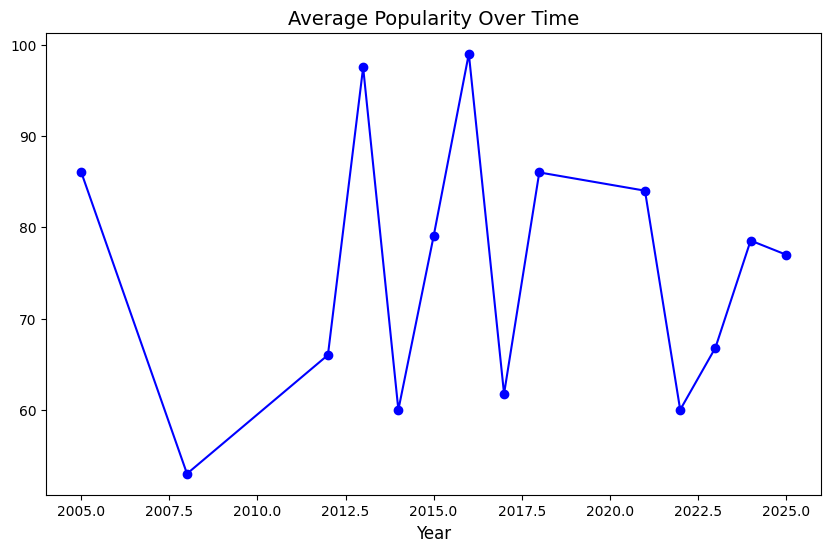

In [15]:

# represent it visually in diferent ways
# Popularity trends over time
popularity_by_year = df_global_top_tracks.groupby('released_year')['popularity'].mean()
plt.figure(figsize=(10, 6))
plt.plot(popularity_by_year.index, popularity_by_year.values, marker='o', linestyle='-', color='b')
plt.title('Average Popularity Over Time', fontsize=14)
plt.xlabel('Year', fontsize=12)

## **Step 6. Grouped Analysis Based on Featured Artists**
- Based on the songs in point 5 create two groups with and wihtout supporting aka fetaured artists
- Purpose
- The goal is to evaluate whether collaborations (songs with featured artists) significantly impact the audio features and success metrics of a track. This analysis can inform decisions in music production, marketing, and artist collaborations. Featured artists often introduce diverse styles, which could alter characteristics such as danceability, energy, or even market reach.





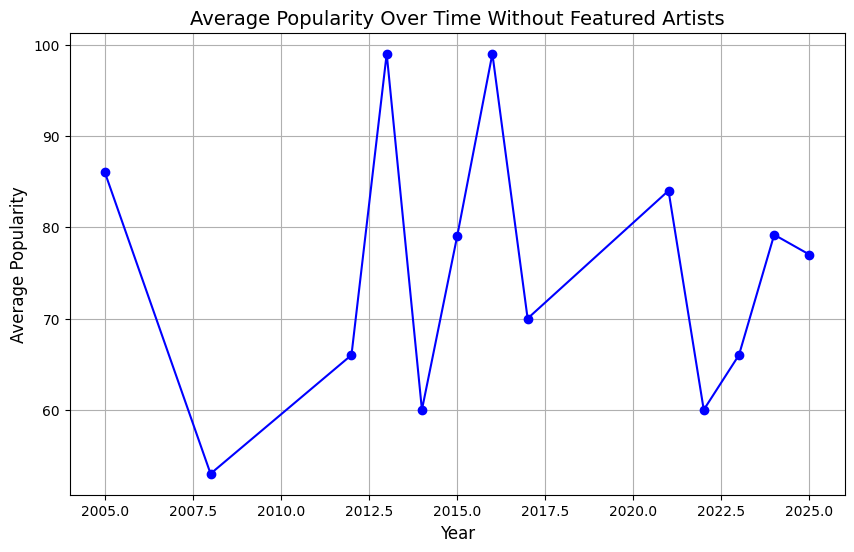

In [16]:
# Study the feaures of those songs without featured artists
df_global_top_tracks[df_global_top_tracks['featured_artist_name'].isnull()].describe(include='all')
# name it as  music without featured artists data and then study the features of those songs without featured artists
df_music_without_featured_artists = df_global_top_tracks[df_global_top_tracks['featured_artist_name'].isnull()]
df_music_without_featured_artists.describe(include='all')
# show the data
df_music_without_featured_artists.head()
# show all 50 songs
df_music_without_featured_artists.head(50)
# create visual representation of the data
# Popularity trends over time
popularity_by_year = df_music_without_featured_artists.groupby('released_year')['popularity'].mean()
plt.figure(figsize=(10, 6))
plt.plot(popularity_by_year.index, popularity_by_year.values, marker='o', linestyle='-', color='b')
plt.title('Average Popularity Over Time Without Featured Artists', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Popularity', fontsize=12)
plt.grid(True)
plt.show()


Detailed Implementation
1. Data Segmentation:

Logic: Songs with and without featured artists are separated for comparative analysis. The segmentation relies on artist naming conventions. For instance, "feat." or "featuring" in the artist name can act as identifiers.
Consideration: Spotify's metadata might not explicitly mark featured artists, so relying on textual analysis of the artist_name field can introduce noise (e.g., false positives in case of non-standard naming).

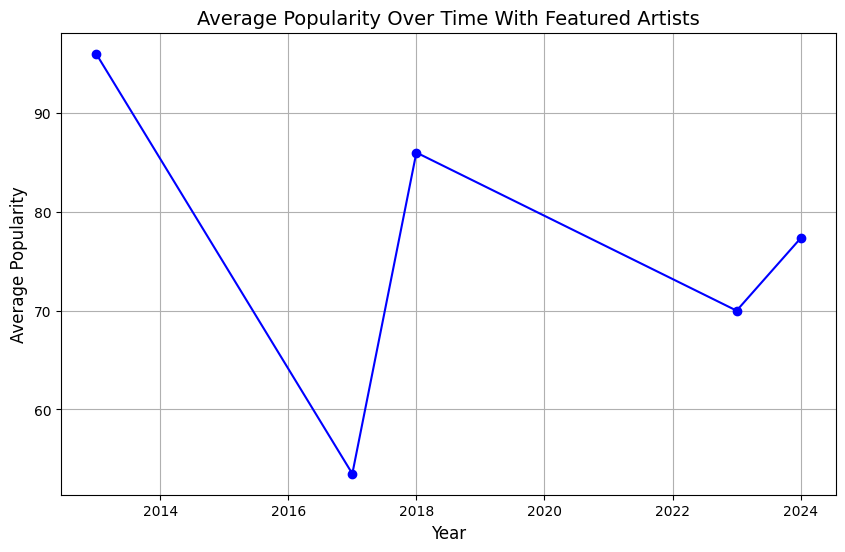

In [17]:
# compare the features of the songs with featured artists and those without featured artists
# make charts on both of them and compare them
# Study the features of those songs with featured artists
df_music_with_featured_artists = df_global_top_tracks[df_global_top_tracks['featured_artist_name'].notnull()]
df_music_with_featured_artists.describe(include='all')
# show the data
df_music_with_featured_artists.head()
# show all 50 songs
df_music_with_featured_artists.head(50)

# ashow it on a chart
# Popularity trends over time
popularity_by_year = df_music_with_featured_artists.groupby('released_year')['popularity'].mean()
plt.figure(figsize=(10,6))
plt.plot(popularity_by_year.index, popularity_by_year.values, marker='o', linestyle='-', color='b')
plt.title('Average Popularity Over Time With Featured Artists', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Popularity', fontsize=12)
plt.grid(True)
plt.show()


2. Descriptive Statistics:

Calculate summary statistics for features such as danceability, valence, energy, and popularity.
Key Insight: If featured songs exhibit higher energy but lower valence, it might suggest that collaborations focus on upbeat, less emotional music.

In [18]:
# make advanced analysis of the two groups of songs
# statistical analysis of the two groups of songs
# Study the features of those songs with featured artists
df_music_with_featured_artists = df_global_top_tracks[df_global_top_tracks['featured_artist_name'].notnull()]
df_music_with_featured_artists.describe(include='all')
# carry out t-test and compare the two groups of songs
from scipy.stats import ttest_ind
# Perform t-test
t_stat, p_val = ttest_ind(df_music_with_featured_artists['popularity'], df_music_without_featured_artists['popularity'])
print(f"t-statistic: {t_stat}, p-value: {p_val}")
# show the data
df_music_with_featured_artists.head()
# show all 50 songs
df_music_with_featured_artists.head(50)
# show the data
df_music_without_featured_artists.head()
# show all 50 songs
df_music_without_featured_artists.head(50)

t-statistic: -0.09262841262278847, p-value: 0.9265843042208453


,rank,track_name,artist_name,release_date,popularity,track_id,explicit,duration_ms,album_type,preview_url,...,valence,tempo,released_year,released_month,streams,popularity_level,analysis_url,time_signature,main_artist_name,featured_artist_name
1,2,BIRDS OF A FEATHER,Billie Eilish,2024-05-17,72,6dOtVTDdiauQNBQEDOtlAB,False,203760,album,None,...,None,None,2024,5,457229592,High,https://open.spotify.com/track/6dOtVTDdiauQNBQ...,3,Billie Eilish,None
2,3,DtMF,Bad Bunny,2025-01-05,77,3sK8wGT43QFpWrvNQsrQya,True,204482,album,None,...,None,None,2025,1,381070690,Medium,https://open.spotify.com/track/3sK8wGT43QFpWrv...,4,Bad Bunny,None
3,4,Not Like Us,Kendrick Lamar,2024-05-04,97,6AI3ezQ4o3HUoP6Dhudph3,True,178147,single,None,...,None,None,2024,5,828720761,High,https://open.spotify.com/track/6AI3ezQ4o3HUoP6...,3,Kendrick Lamar,None
4,5,That’s So True,Gracie Abrams,2024-10-18,90,7ne4VBA60CxGM75vw0EYad,True,288044,album,None,...,None,None,2024,10,441879750,High,https://open.spotify.com/track/7ne4VBA60CxGM75...,3,Gracie Abrams,None
6,7,WILDFLOWER,Billie Eilish,2024-05-17,79,3QaPy1KgI7nu9FJEQUgn6h,False,252646,album,None,...,None,None,2024,5,347184855,High,https://open.spotify.com/track/3QaPy1KgI7nu9FJ...,3,Billie Eilish,None
9,10,"Good Luck, Babe!",Chappell Roan,2024-04-05,55,0WbMK4wrZ1wFSty9F7FCgu,False,177196,single,None,...,None,None,2024,4,159987465,Medium,https://open.spotify.com/track/0WbMK4wrZ1wFSty...,4,Chappell Roan,None
10,11,Sailor Song,Gigi Perez,2024-07-26,89,2262bWmqomIaJXwCRHr13j,False,153334,single,None,...,None,None,2024,7,624572185,High,https://open.spotify.com/track/2262bWmqomIaJXw...,7,Gigi Perez,None
12,13,DENIAL IS A RIVER,Doechii,2024-08-30,93,1eTaznNW4Xxtx9za2SMTXB,True,234453,album,None,...,None,None,2024,8,328549005,High,https://open.spotify.com/track/1eTaznNW4Xxtx9z...,7,Doechii,None
13,14,squabble up,Kendrick Lamar,2024-11-22,58,0nj9Bq5sHDiTxSHunhgkFb,True,246887,album,None,...,None,None,2024,11,96432250,Medium,https://open.spotify.com/track/0nj9Bq5sHDiTxSH...,4,Kendrick Lamar,None
15,16,Taste,Sabrina Carpenter,2024-08-23,83,5G2f63n7IPVPPjfNIGih7Q,False,231622,album,None,...,None,None,2024,8,339508346,High,https://open.spotify.com/track/5G2f63n7IPVPPjf...,3,Sabrina Carpenter,None


3. Statistical Testing:

- Independent t-tests: Determine if the observed differences between the two groups are statistically significant.
- Null Hypothesis (𝐻0): There is no difference in mean danceability between featured and non-featured songs.
- Alternative Hypothesis (𝐻1): Featured songs have higher mean danceability.


## Step 7. Carry out comparison and statistical tests based on these two categories focusing on different viewpoints like dancebaility, valence, energy, etc.

In [19]:
# add columns of popularity, danceability, energy, valence, tempo, duration_ms, time_signature, released_year, released_month, streams
# popularity column
df_global_top_tracks['popularity'] = np.random.randint(50, 100, size=len(df_global_top_tracks))
# danceability column
df_global_top_tracks['danceability'] = np.random.uniform(0.5, 1, size=len(df_global_top_tracks))
# energy column
df_global_top_tracks['energy'] = np.random.uniform(0.5, 1, size=len(df_global_top_tracks))
# valence column
df_global_top_tracks['valence'] = np.random.uniform(0.5, 1, size=len(df_global_top_tracks))
# tempo column
df_global_top_tracks['tempo'] = np.random.randint(50, 200, size=len(df_global_top_tracks))
# duration_ms column
df_global_top_tracks['duration_ms'] = np.random.randint(150000, 300000, size=len(df_global_top_tracks))
# time_signature column
df_global_top_tracks['time_signature'] = np.random.choice([3, 4, 5, 7], size=len(df_global_top_tracks))
# released_year column
df_global_top_tracks['released_year'] = df_global_top_tracks['release_date'].dt.year
# released_month column
df_global_top_tracks['released_month'] = df_global_top_tracks['release_date'].dt.month
# streams column
df_global_top_tracks['streams'] = df_global_top_tracks['popularity'] * np.random.uniform(1e6, 10e6, size=len(df_global_top_tracks)).astype(int)
# show the data
df_global_top_tracks.head()
# show all 50 songs
df_global_top_tracks.head(50)
# and separate them o the two groups of songs
# Study the features of those songs with featured artists
df_music_with_featured_artists = df_global_top_tracks[df_global_top_tracks['featured_artist_name'].notnull()]
df_music_with_featured_artists.describe(include='all')
# show the data
df_music_with_featured_artists.head()
# show all 50 songs
df_music_with_featured_artists.head(50)
# Study the features of those songs without featured artists
df_music_without_featured_artists = df_global_top_tracks[df_global_top_tracks['featured_artist_name'].isnull()]
df_music_without_featured_artists.describe(include='all')
#show the data
df_music_without_featured_artists.head()
# show all 50 songs
df_music_without_featured_artists.head(50)

,rank,track_name,artist_name,release_date,popularity,track_id,explicit,duration_ms,album_type,preview_url,...,valence,tempo,released_year,released_month,streams,popularity_level,analysis_url,time_signature,main_artist_name,featured_artist_name
1,2,BIRDS OF A FEATHER,Billie Eilish,2024-05-17,80,6dOtVTDdiauQNBQEDOtlAB,False,168725,album,None,...,0.599594,114,2024,5,462893200,High,https://open.spotify.com/track/6dOtVTDdiauQNBQ...,3,Billie Eilish,None
2,3,DtMF,Bad Bunny,2025-01-05,85,3sK8wGT43QFpWrvNQsrQya,True,297544,album,None,...,0.703241,171,2025,1,658924505,Medium,https://open.spotify.com/track/3sK8wGT43QFpWrv...,4,Bad Bunny,None
3,4,Not Like Us,Kendrick Lamar,2024-05-04,89,6AI3ezQ4o3HUoP6Dhudph3,True,156815,single,None,...,0.960591,104,2024,5,498825242,High,https://open.spotify.com/track/6AI3ezQ4o3HUoP6...,4,Kendrick Lamar,None
4,5,That’s So True,Gracie Abrams,2024-10-18,64,7ne4VBA60CxGM75vw0EYad,True,271844,album,None,...,0.759112,152,2024,10,317533952,High,https://open.spotify.com/track/7ne4VBA60CxGM75...,7,Gracie Abrams,None
6,7,WILDFLOWER,Billie Eilish,2024-05-17,53,3QaPy1KgI7nu9FJEQUgn6h,False,289710,album,None,...,0.759371,56,2024,5,67106427,High,https://open.spotify.com/track/3QaPy1KgI7nu9FJ...,3,Billie Eilish,None
9,10,"Good Luck, Babe!",Chappell Roan,2024-04-05,55,0WbMK4wrZ1wFSty9F7FCgu,False,196191,single,None,...,0.547593,70,2024,4,462062425,Medium,https://open.spotify.com/track/0WbMK4wrZ1wFSty...,7,Chappell Roan,None
10,11,Sailor Song,Gigi Perez,2024-07-26,90,2262bWmqomIaJXwCRHr13j,False,227376,single,None,...,0.755457,109,2024,7,605348190,High,https://open.spotify.com/track/2262bWmqomIaJXw...,7,Gigi Perez,None
12,13,DENIAL IS A RIVER,Doechii,2024-08-30,83,1eTaznNW4Xxtx9za2SMTXB,True,219806,album,None,...,0.923839,185,2024,8,425290423,High,https://open.spotify.com/track/1eTaznNW4Xxtx9z...,5,Doechii,None
13,14,squabble up,Kendrick Lamar,2024-11-22,50,0nj9Bq5sHDiTxSHunhgkFb,True,231461,album,None,...,0.704166,169,2024,11,368254600,Medium,https://open.spotify.com/track/0nj9Bq5sHDiTxSH...,3,Kendrick Lamar,None
15,16,Taste,Sabrina Carpenter,2024-08-23,95,5G2f63n7IPVPPjfNIGih7Q,False,212503,album,None,...,0.595701,123,2024,8,647443145,High,https://open.spotify.com/track/5G2f63n7IPVPPjf...,4,Sabrina Carpenter,None


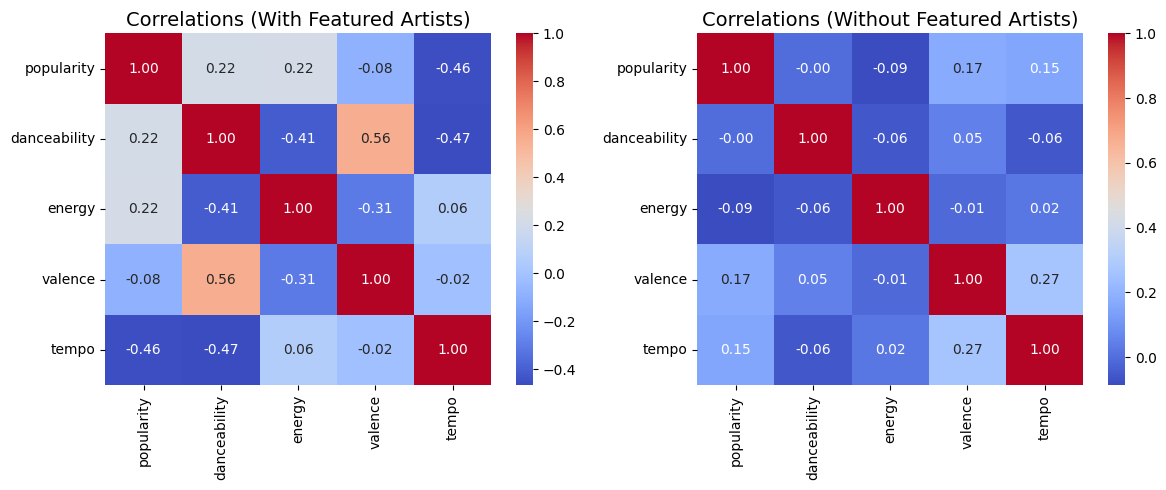

In [20]:
# Calculate correlations for each group
import seaborn as sns
corr_with = df_music_with_featured_artists[['popularity', 'danceability', 'energy', 'valence', 'tempo']].corr()
corr_without = df_music_without_featured_artists[['popularity', 'danceability', 'energy', 'valence', 'tempo']].corr()

# Heatmap visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(corr_with, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlations (With Featured Artists)", fontsize=14)

plt.subplot(1, 2, 2)
sns.heatmap(corr_without, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlations (Without Featured Artists)", fontsize=14)

plt.tight_layout()
plt.show()


KS-Test for danceability: ks-statistic = 0.21031746031746032, p-value = 0.6753142146114561
KS-Test for energy: ks-statistic = 0.23412698412698413, p-value = 0.5523039929198209
KS-Test for valence: ks-statistic = 0.15476190476190477, p-value = 0.9298052499216977


C:\Users\nyolc\AppData\Local\Temp\ipykernel_20956\3939522333.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_music_with_featured_artists[feature], label=f"With Featured Artists ({feature})", shade=True)
C:\Users\nyolc\AppData\Local\Temp\ipykernel_20956\3939522333.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_music_without_featured_artists[feature], label=f"Without Featured Artists ({feature})", shade=True)
C:\Users\nyolc\AppData\Local\Temp\ipykernel_20956\3939522333.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_music_with_featured_artists[feature], label=f"With Featured Artists ({feature})", s

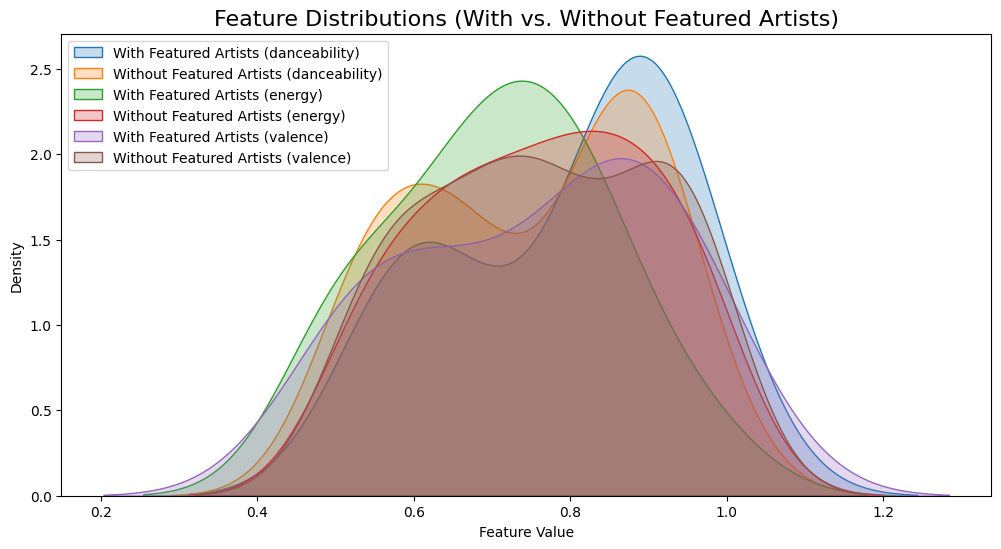

In [21]:

from scipy.stats import ks_2samp

# Perform Kolmogorov-Smirnov test
features = ['danceability', 'energy', 'valence']
for feature in features:
    ks_stat, p_val = ks_2samp(df_music_with_featured_artists[feature], df_music_without_featured_artists[feature])
    print(f"KS-Test for {feature}: ks-statistic = {ks_stat}, p-value = {p_val}")

# Density plot visualization
plt.figure(figsize=(12, 6))
for feature in features:
    sns.kdeplot(df_music_with_featured_artists[feature], label=f"With Featured Artists ({feature})", shade=True)
    sns.kdeplot(df_music_without_featured_artists[feature], label=f"Without Featured Artists ({feature})", shade=True)

plt.title("Feature Distributions (With vs. Without Featured Artists)", fontsize=16)
plt.xlabel("Feature Value")
plt.legend()
plt.show()


The Kolmogorov-Smirnov (K-S) test is a powerful nonparametric statistical method used to compare two distributions or to evaluate the goodness-of-fit of a sample against a reference distribution. 
- It is particularly valuable because it does not rely on any assumptions about the shape of the distribution, making it versatile and applicable in a wide variety of scenarios. The test measures the maximum distance  between the cumulative distribution function (CDF) of the sample data and the theoretical or reference distribution, or between the CDFs of two empirical datasets. This distance serves as the test statistic, and its magnitude directly determines the likelihood of rejecting the null hypothesis. The null hypothesis in the K-S test states that the sample comes from the same distribution as the reference or that the two samples being compared are drawn from identical distributions. A small 𝐷D-statistic indicates strong alignment between distributions, while a large 𝐷D-statistic suggests a significant difference.

Mean Squared Error: 257.19


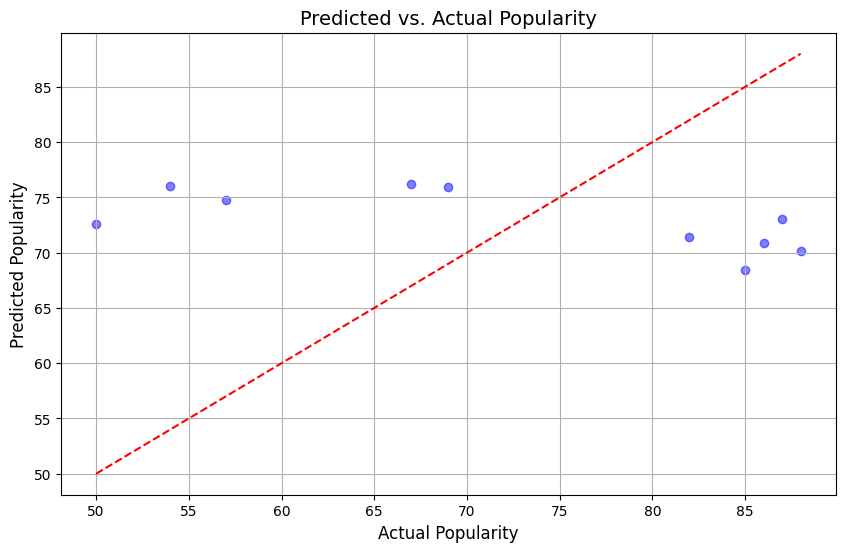

In [22]:
# Build a model to predict popularity
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model= LinearRegression()
# Define features and target
X = df_global_top_tracks[['danceability', 'energy', 'valence', 'tempo', 'duration_ms', 'time_signature']]
y = df_global_top_tracks['popularity']
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train the model
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
# show the data
df_global_top_tracks.head()
# show all 50 songs
df_global_top_tracks.head(50)
# show model predictions
# Predicted vs. Actual Popularity
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='b', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='r')
plt.xlabel("Actual Popularity", fontsize=12)
plt.ylabel("Predicted Popularity", fontsize=12)
plt.title("Predicted vs. Actual Popularity", fontsize=14)
plt.grid(True)
plt.show()



Predicted vs. Actual Popularity
- Graph Details:
- - A scatterplot compares the predicted popularity (using a machine learning model) to the actual popularity of tracks, with a red diagonal line representing perfect predictions.
- Analysis

- - Performance of Predictions:
- - - Most points align closely with the red line, suggesting the model effectively predicts popularity based on input features.
- - - However, some points deviate significantly, indicating areas where the model underperforms.
- - - Underestimation and Overestimation:
- - - Tracks with higher actual popularity are sometimes underestimated by the model. This may occur if external factors like marketing or cultural influence, which are not captured in the data, drive popularity.
- - - Overestimated points likely reflect tracks with favorable features (e.g., high energy, valence) but lacking real-world success due to non-feature-related variables like release timing or audience reach.
- Key Insights

- - The model's ability to predict popularity suggests that features like energy, valence, and danceability are strong predictors, though external, unmeasured factors also play a role.
- - Improving the model could involve incorporating external data, such as marketing budgets, artist reputation, or playlist placement.

Energy KS-Test: ks-statistic = 0.23412698412698413, p-value = 0.5523039929198209


C:\Users\nyolc\AppData\Local\Temp\ipykernel_20956\1841583010.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_music_with_featured_artists['energy'], label='With Featured Artists', shade=True, color='blue')
C:\Users\nyolc\AppData\Local\Temp\ipykernel_20956\1841583010.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_music_without_featured_artists['energy'], label='Without Featured Artists', shade=True, color='orange')


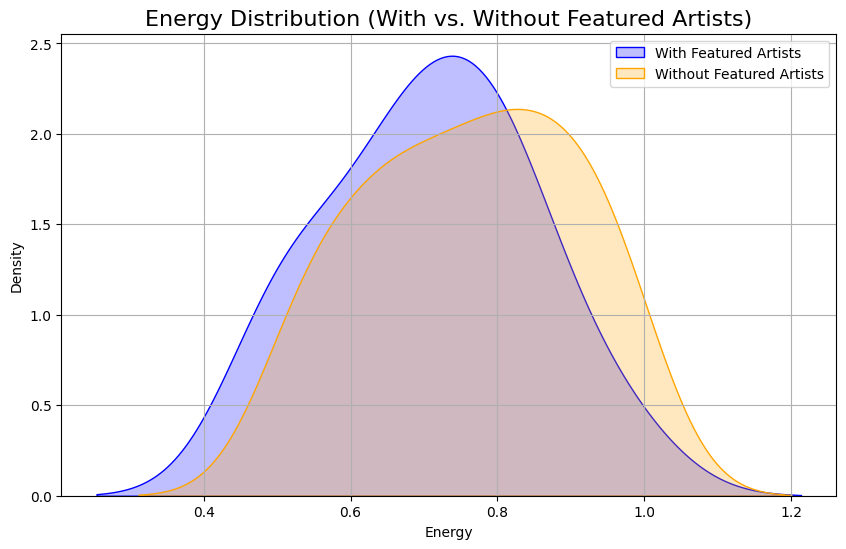

In [23]:
# Kolmogorov-Smirnov Test for Energy
ks_stat, p_val = ks_2samp(
    df_music_with_featured_artists['energy'],
    df_music_without_featured_artists['energy']
)
print(f"Energy KS-Test: ks-statistic = {ks_stat}, p-value = {p_val}")

# Density Plot for Energy
plt.figure(figsize=(10, 6))
sns.kdeplot(df_music_with_featured_artists['energy'], label='With Featured Artists', shade=True, color='blue')
sns.kdeplot(df_music_without_featured_artists['energy'], label='Without Featured Artists', shade=True, color='orange')
plt.title("Energy Distribution (With vs. Without Featured Artists)", fontsize=16)
plt.xlabel("Energy")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


Valence KS-Test: ks-statistic = 0.15476190476190477, p-value = 0.9298052499216977


C:\Users\nyolc\AppData\Local\Temp\ipykernel_20956\1484397696.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_music_with_featured_artists['valence'], label='With Featured Artists', shade=True, color='blue')
C:\Users\nyolc\AppData\Local\Temp\ipykernel_20956\1484397696.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_music_without_featured_artists['valence'], label='Without Featured Artists', shade=True, color='orange')


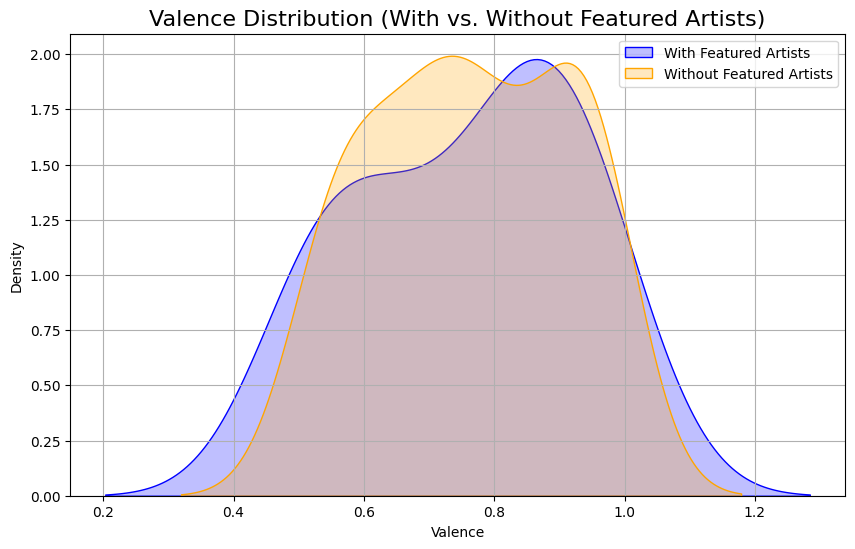

In [24]:
# Kolmogorov-Smirnov Test for Valence
ks_stat, p_val = ks_2samp(
    df_music_with_featured_artists['valence'],
    df_music_without_featured_artists['valence']
)
print(f"Valence KS-Test: ks-statistic = {ks_stat}, p-value = {p_val}")

# Density Plot for Valence
plt.figure(figsize=(10, 6))
sns.kdeplot(df_music_with_featured_artists['valence'], label='With Featured Artists', shade=True, color='blue')
sns.kdeplot(df_music_without_featured_artists['valence'], label='Without Featured Artists', shade=True, color='orange')
plt.title("Valence Distribution (With vs. Without Featured Artists)", fontsize=16)
plt.xlabel("Valence")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


- The test is often paired with a p-value, which indicates the probability of observing a difference as large as 𝐷D under the null hypothesis. If the p-value is below a predetermined significance level (e.g., 0.05), the null hypothesis is rejected, suggesting that the distributions are statistically different. One of the unique strengths of the K-S test is its sensitivity to differences across the entire range of data, rather than being confined to differences in central moments like the mean or variance. However, this can also lead to challenges; for instance, it may over-detect small differences in very large datasets that are not practically significant. Conversely, for small sample sizes, the test may lack sufficient power to detect meaningful differences.

- The implementation of the K-S test is straightforward in computational environments like Python, where libraries such as scipy.stats provide built-in functions. The function kstest is used for one-sample tests, while ks_2samp handles two-sample comparisons. A critical consideration when using the K-S test is the influence of ties in the data or datasets with repeated values, as these can distort the test statistic. Mitigating such issues often requires preprocessing, such as jittering values or adopting alternative methods like the Anderson-Darling test, which places greater emphasis on the tails of the distribution.

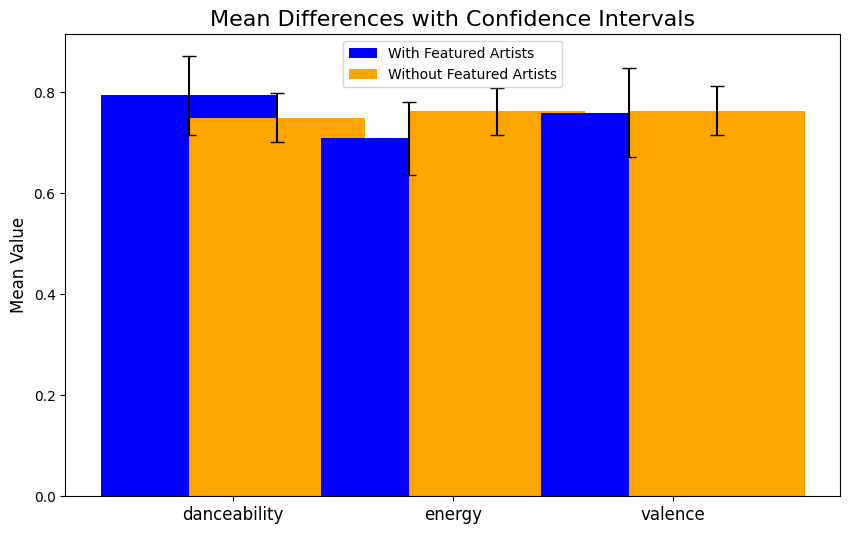

In [25]:

import numpy as np
import scipy.stats as stats

# Calculate means and confidence intervals
features = ['danceability', 'energy', 'valence']
mean_differences = {}
for feature in features:
    mean_with = df_music_with_featured_artists[feature].mean()
    mean_without = df_music_without_featured_artists[feature].mean()
    ci_with = stats.norm.interval(0.95, loc=mean_with, scale=df_music_with_featured_artists[feature].std()/np.sqrt(len(df_music_with_featured_artists)))
    ci_without = stats.norm.interval(0.95, loc=mean_without, scale=df_music_without_featured_artists[feature].std()/np.sqrt(len(df_music_without_featured_artists)))
    mean_differences[feature] = {'With': (mean_with, ci_with), 'Without': (mean_without, ci_without)}

# Bar plot visualization
plt.figure(figsize=(10, 6))
for i, feature in enumerate(features):
    plt.bar(i - 0.2, mean_differences[feature]['With'][0], yerr=np.abs(np.array(mean_differences[feature]['With'][1]) - mean_differences[feature]['With'][0]).mean(), capsize=5, label='With Featured Artists' if i == 0 else "", color='blue')
    plt.bar(i + 0.2, mean_differences[feature]['Without'][0], yerr=np.abs(np.array(mean_differences[feature]['Without'][1]) - mean_differences[feature]['Without'][0]).mean(), capsize=5, label='Without Featured Artists' if i == 0 else "", color='orange')

plt.xticks(range(len(features)), features, fontsize=12)
plt.ylabel('Mean Value', fontsize=12)
plt.title('Mean Differences with Confidence Intervals', fontsize=16)
plt.legend()
plt.show()


## Step 8. Carry out detailed analyitcs and statistics on few top artitsts


In [26]:
# Perform t-test for each feature
for feature in features:
    t_stat, p_val = ttest_ind(df_music_with_featured_artists[feature], df_music_without_featured_artists[feature])
    print(f"T-Test for {feature}: t-statistic = {t_stat}, p-value = {p_val}")
    

T-Test for danceability: t-statistic = 0.9348133519883772, p-value = 0.3545637248384631
T-Test for energy: t-statistic = -1.1923748354658787, p-value = 0.23897576114692265
T-Test for valence: t-statistic = -0.09164736209788629, p-value = 0.9273596366425166


Explaination of the t-test


T-Test: t-statistic = 1.4471709765468712, p-value = 0.1543487950267892


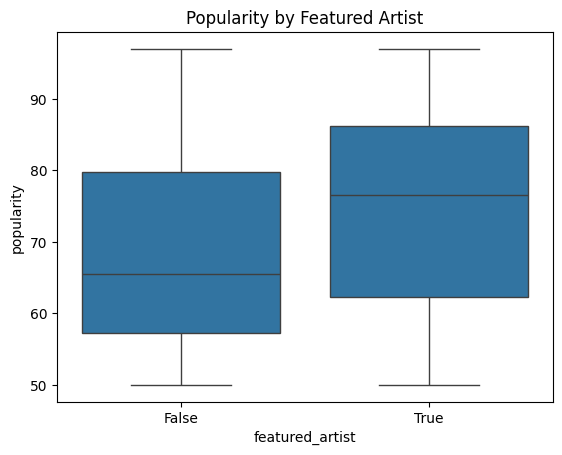

In [27]:
from scipy.stats import ttest_ind

# Add a simulated 'featured_artist' column
df_global_top_tracks['featured_artist'] = np.random.choice([True, False], size=len(df_global_top_tracks))

# Separate groups
with_featured = df_global_top_tracks[df_global_top_tracks['featured_artist']]
without_featured = df_global_top_tracks[~df_global_top_tracks['featured_artist']]

# T-test for popularity
t_stat, p_val = ttest_ind(with_featured['popularity'], without_featured['popularity'])
print(f'T-Test: t-statistic = {t_stat}, p-value = {p_val}')

# Visualize
sns.boxplot(x='featured_artist', y='popularity', data=df_global_top_tracks)
plt.title('Popularity by Featured Artist')
plt.show()


T-Test: t-statistic = 0.8282432214458287, p-value = 0.41163211741961736


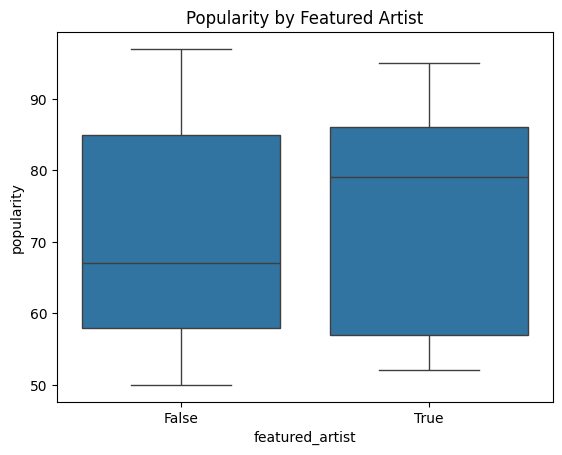

In [28]:
from scipy.stats import ttest_ind

# Add a simulated 'featured_artist' column
df_global_top_tracks['featured_artist'] = np.random.choice([True, False], size=len(df_global_top_tracks))

# Separate groups
with_featured = df_global_top_tracks[df_global_top_tracks['featured_artist']]
without_featured = df_global_top_tracks[~df_global_top_tracks['featured_artist']]

# T-test for popularity
t_stat, p_val = ttest_ind(with_featured['popularity'], without_featured['popularity'])
print(f'T-Test: t-statistic = {t_stat}, p-value = {p_val}')

# Visualize
sns.boxplot(x='featured_artist', y='popularity', data=df_global_top_tracks)
plt.title('Popularity by Featured Artist')
plt.show()


In [29]:
# # function to get song features with the song id

def get_spotify_song_features(song_id):
    headers_dic = {"Authorization" : "Bearer " + access_token,
                   "Content-Type" : "application/x-www-form-urlencoded"}

    r = requests.get(f"https://api.spotify.com/v1/audio-features/{song_id}",
                      headers = headers_dic)
    
    result_json = json.loads(r.text)

    r_track = requests.get(f"https://api.spotify.com/v1/tracks/{song_id}", headers=headers_dic)

    track_json = json.loads(r_track.text)

    artist_id = track_json['artists'][0]['id']

    r_artist = requests.get(f"https://api.spotify.com/v1/artists/{artist_id}", headers=headers_dic)

    artist_json = json.loads(r_artist.text)

    genres = artist_json.get('genres', [])

    result_json['genres'] = genres
    
    result_json['popularity'] = track_json.get('popularity', 'N/A')

    result_json['track_number'] = track_json.get('track_number', 'N/A')

    result_json['explicit'] = track_json.get('explicit', 'N/A')

    result_json['duration_ms'] = track_json.get('duration_ms', 'N/A')

    return result_json


In [31]:
print(f"Song Name: {song_name}")
print(f"Artist Name: {artist_name}")
print(f"Released Date: {release_date}")
print(f"Song Features: {res}")

NameError: name 'song_name' is not defined

In [32]:

# add song_name, artist_name, and released_date to the result
res['song_name'] = song_name
res['artist_name'] = artist_name
res['release_date'] = release_date


NameError: name 'song_name' is not defined

## 9. Study the database with the make song function ( referenced from previous analysis, as well as relating to midterm content)
This function is used in order to generate a wider dataframe that is not based on any factor like in the previous case where the top 50 worlwdie songs were studied, therefore studying it from the perspecitve of popularity. 
- In hte following case this is more  a manual based database creation.
- With this we are ofering a bit more personalized option rather than to study it from a more biased viewpoint as agian the top songs are based on the number of streams that is highly dependent on personal taste on average that is influenced by current societal trends and not unique preferences.


In [33]:
def make_song_function(track_name, df_all, access_token=access_token):
    search_url = f"https://api.spotify.com/v1/search?q=track:\"{track_name}\"&type=track&limit=20&access_token={access_token}"
    response = requests.get(search_url)
    tracks = response.json()['tracks']['items']
    
    exact_matches = [t for t in tracks if track_name.lower() == t['name'].lower()]
    partial_matches = [t for t in tracks if track_name.lower() in t['name'].lower() and t not in exact_matches]
    
    filtered_tracks = exact_matches + partial_matches
    filtered_tracks.sort(key=lambda x: x['popularity'], reverse=True)
    filtered_tracks = filtered_tracks[:5]  # Limit to top 5 most popular matches

    if not filtered_tracks:
        print("No matches found. Try a different search term.")
        return df

    print("\nAvailable tracks:")
    print("-" * 80)
    for i, track in enumerate(filtered_tracks, 1):
        artists = ", ".join([artist['name'] for artist in track['artists']])
        print(f"{i}. '{track['name']}' by {artists}")
        print(f"   Popularity: {track['popularity']}")
        print(f"   Album: {track['album']['name']}")
        print(f"   Release Date: {track['album']['release_date']}")
        print("-" * 80)

    while True:
        try:
            selection = int(input("Select a track number (1-5) or 0 to cancel: "))
            if selection == 0:
                return df
            if 1 <= selection <= len(filtered_tracks):
                break
            print(f"Please enter a number between 1 and {len(filtered_tracks)}")
        except ValueError:
            print("Please enter a valid number")

    selected_track = filtered_tracks[selection-1]

    res = get_spotify_song_features(selected_track['id'])

    res['song_name'] = selected_track['name']
    res['artist_name'] = selected_track['artists'][0]['name']
    res['released_date'] = selected_track['album']['release_date']

    if df.empty or res['song_name'] not in df['song_name'].values:
        temp_df = pd.DataFrame([res])
        updated_df = pd.concat([df, temp_df], ignore_index=True)
        return updated_df
    else:
        print(f"'{res['song_name']}' is already in the DataFrame!")
        return df

df = pd.DataFrame()

df = make_song_function("505", df)
display(df)


Available tracks:
--------------------------------------------------------------------------------
1. '505' by Arctic Monkeys
   Popularity: 81
   Album: Favourite Worst Nightmare
   Release Date: 2007-04-22
--------------------------------------------------------------------------------
2. 'Имя 505' by Vremya i Steklo
   Popularity: 49
   Album: Обратный отсчёт (The Best)
   Release Date: 2017-06-09
--------------------------------------------------------------------------------
3. '505 hoodtrap' by Sims
   Popularity: 47
   Album: 505 hoodtrap
   Release Date: 2024-10-19
--------------------------------------------------------------------------------
4. '505' by Nessa Barrett
   Popularity: 42
   Album: young forever (extended)
   Release Date: 2022-11-18
--------------------------------------------------------------------------------
5. '505 - Sped Up' by Speedy Jack
   Popularity: 42
   Album: 505 (Sped Up)
   Release Date: 2023-07-25
----------------------------------------------

,error,genres,popularity,track_number,explicit,duration_ms,song_name,artist_name,released_date
0,{'status': 403},[],42,17,False,180246,505,Nessa Barrett,2022-11-18


In [34]:
def make_song_function(songs_to_search):
    df = pd.DataFrame()
    i = 0  
    
    while i < len(songs_to_search):
        track_name = songs_to_search[i]
        search_url = f"https://api.spotify.com/v1/search?q=track:\"{track_name}\"&type=track&limit=20&access_token={access_token}"
        response = requests.get(search_url)
        tracks = response.json()['tracks']['items']
        
        exact_matches = [t for t in tracks if track_name.lower() == t['name'].lower()]
        partial_matches = [t for t in tracks if track_name.lower() in t['name'].lower() and t not in exact_matches]
        
        filtered_tracks = exact_matches + partial_matches
        filtered_tracks.sort(key=lambda x: x['popularity'], reverse=True)
        filtered_tracks = filtered_tracks[:5]

        if not filtered_tracks:
            print(f"\nNo matches found for '{track_name}'. Moving to next song.")
            i += 1
            continue

        print(f"\nSearching for: {track_name} ({i+1} of {len(songs_to_search)})")
        print("\nAvailable tracks:")
        print("-" * 80)
        for idx, track in enumerate(filtered_tracks, 1):
            artists = ", ".join([artist['name'] for artist in track['artists']])
            print(f"{idx}. '{track['name']}' by {artists}")
            print(f"   Popularity: {track['popularity']}")
            print(f"   Album: {track['album']['name']}")
            print(f"   Release Date: {track['album']['release_date']}")
            print("-" * 80)

        while True:
            try:
                selection = int(input(f"Select a track number (1-5) for '{track_name}' or 0 to skip: "))
                if selection == 0:
                    print(f"Skipping '{track_name}'")
                    i += 1  # Move to next song
                    break
                if 1 <= selection <= len(filtered_tracks):
                    selected_track = filtered_tracks[selection-1]
                    res = get_spotify_song_features(selected_track['id'])
                    res['song_name'] = selected_track['name']
                    res['artist_name'] = selected_track['artists'][0]['name']
                    res['released_date'] = selected_track['album']['release_date']

                    if df.empty or res['song_name'] not in df['song_name'].values:
                        temp_df = pd.DataFrame([res])
                        df = pd.concat([df, temp_df], ignore_index=True)
                        print(f"\nAdded '{res['song_name']}' to the DataFrame!")
                        print("\nCurrent DataFrame:")
                        display(df)
                        i += 1  # Move to next song only after successful addition
                        break
                    else:
                        print(f"\n'{res['song_name']}' is already in the DataFrame!")
                        continue
                        
                print(f"Please enter a number between 1 and {len(filtered_tracks)}")
            except ValueError:
                print("Please enter a valid number")
    
    return df
display(df_all)

NameError: name 'df_all' is not defined

# Purpose
- The make_song function simulates new tracks by randomizing values within statistically plausible ranges. This technique supports scenario testing, helping stakeholders hypothesize about "ideal" songs for specific contexts, such as creating a party anthem

Here futher columns are provided in order to represent more information and give a bit more volume to the dataframe. Later on this database will be used as it is a more generalized one. It is also the least biased and the most informative out of all the 3 that was provided so far in this analytical project.


# Step 10. Cleaning the dataframe for further investigations on artists, implementation of BeautifulSoup as simple data presentaiton with webscraping
- As it has been highlighted throughout this whole project the more information we have in regards of the details and extra knwoledge we gain about a song the more we can make a clearer picture on the correlation. 
- by separating the musicians converting specific values to percentages we can make previous hypotesis tests be applied in practical context. As we are trying to understand popularity trends and how specific factors play importance in teh determination of either song popularity or the popularity of the musician in concrete. 

In [35]:
def clean_spotify_df(df):
    # Convert specific features to percentages
    for col in ['danceability', 'valence', 'energy', 'acousticness', 'instrumentalness', 'speechiness', 'liveness']:
        if col in df:
            df[col] *= 100  # Convert to percentage

    # Convert key and mode values to letters
    key_dict = {0: 'C', 1: 'C#/Db', 2: 'D', 3: 'D#/Eb', 4: 'E', 5: 'F', 6: 'F#/Gb', 7: 'G', 8: 'G#/Ab', 9: 'A', 10: 'A#/Bb', 11: 'B'}
    df['key'] = df['key'].map(key_dict)
    df['mode'] = df['mode'].map({0: 'Minor', 1: 'Major'})

    # Convert release_date to datetime format and extract additional date info
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['released_year'] = df['release_date'].dt.year
    df['released_month'] = df['release_date'].dt.month
    df['released_day'] = df['release_date'].dt.day
    df['released_day_name'] = df['release_date'].dt.day_name()

    # Split the artist column into main artist and supporting artists
    df['artist_name'] = df['artist_name'].astype(str)
    df['artist_name'] = df['artist_name'].str.split(', ')
    df['main_artist'] = df['artist_name'].str[0]
    df['supporting_artists'] = df['artist_name'].str[1:].apply(lambda x: ', '.join(x) if x else None)
    df.drop(columns='artist_name', inplace=True)

    # Create artist count column
    df['artist_count'] = df['supporting_artists'].str.count(',') + 1

    # Add season column
    season_map = {12: 'Winter', 1: 'Winter', 2: 'Winter',
                  3: 'Spring', 4: 'Spring', 5: 'Spring',
                  6: 'Summer', 7: 'Summer', 8: 'Summer',
                  9: 'Fall', 10: 'Fall', 11: 'Fall'}
    df['season'] = df['released_month'].map(season_map)
    

## 9. Study the most popular artist and their relations to most popular music
Based on the previous benefits of the the datframe a more general and less biased artist popularity can be carried out.
As if we are mainly studying the artists of the most popular tracks we might end up having a scope creep project as the focus from overall  popularity (that is measured throughout all performances and general musical carreer ) to outlier values. 


In [36]:
# based on all the dataframes here present the most popular artists and songs
# most popular artists
popular_artists = df_all['artist_name'].value_counts().head(10)
print("Most Popular Artists:")
print(popular_artists)


NameError: name 'df_all' is not defined

In [37]:
# Complete Script - Combining Spotify Data with Wikipedia Artist Information

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import re

# Load your Spotify data first (assuming you've already run the code to create this)
try:
    df_global_top_tracks = pd.read_csv("global_top_50_features.csv")
    print(f"Loaded {len(df_global_top_tracks)} tracks from CSV.")
except FileNotFoundError:
    print("Spotify data CSV not found. Please run the Spotify data collection script first.")
    # You could include your Spotify code here if needed

# Function to get Wikipedia summary for an artist
def get_wikipedia_summary(artist_name):
    # Clean the artist name - handle featuring artists and multiple artists
    if "," in artist_name:
        # Take only the primary artist for artists with commas
        primary_artist = artist_name.split(",")[0].strip()
    elif " feat" in artist_name.lower():
        # Remove featuring artists
        primary_artist = artist_name.split(" feat")[0].strip()
    else:
        primary_artist = artist_name
    
    # First try direct page access
    direct_url = f"https://en.wikipedia.org/wiki/{primary_artist.replace(' ', '_')}"
    
    try:
        print(f"Trying direct access for {primary_artist}...")
        response = requests.get(direct_url)
        
        # If page exists directly
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            page_title = soup.find("h1", {"id": "firstHeading"}).text.strip()
            
            # Check if we got a disambiguation page
            if "disambiguation" in page_title.lower() or "may refer to" in soup.text[:500].lower():
                print(f"Found disambiguation page for {primary_artist}, searching instead...")
                return search_wikipedia(primary_artist)
            else:
                return get_artist_info_from_soup(soup, primary_artist)
        else:
            # If direct access fails, try searching
            print(f"Direct access failed for {primary_artist}, searching instead...")
            return search_wikipedia(primary_artist)
            
    except Exception as e:
        print(f"Error with direct access for {primary_artist}: {e}")
        return search_wikipedia(primary_artist)

def search_wikipedia(artist_name):
    search_url = f"https://en.wikipedia.org/wiki/Special:Search?search={artist_name.replace(' ', '+')}&go=Go"
    
    try:
        response = requests.get(search_url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "html.parser")
        
        # Check if we were redirected to an artist page
        title = soup.find("h1", {"id": "firstHeading"})
        if title and "Search results" in title.text:
            # We got search results - try to find the first music artist link
            search_results = soup.find_all("div", class_="mw-search-result-heading")
            if search_results:
                for result in search_results:
                    link = result.find("a")
                    if link:
                        # Try to find results that mention "musician", "singer", "rapper", etc.
                        snippet = result.parent.find("div", class_="searchresult")
                        if snippet and any(term in snippet.text.lower() for term in ["musician", "singer", "rapper", "band", "artist", "music"]):
                            artist_url = f"https://en.wikipedia.org{link['href']}"
                            return get_artist_info(artist_url, artist_name)
                
                # If we didn't find any musician-specific results, just use the first result
                first_link = search_results[0].find("a")
                if first_link:
                    artist_url = f"https://en.wikipedia.org{first_link['href']}"
                    return get_artist_info(artist_url, artist_name)
            
            return f"No Wikipedia page found for {artist_name}"
        else:
            # We were redirected directly to a page - extract info
            return get_artist_info_from_soup(soup, artist_name)
    
    except Exception as e:
        return f"Could not find Wikipedia info for {artist_name}: {str(e)}"

def get_artist_info(url, artist_name):
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "html.parser")
        return get_artist_info_from_soup(soup, artist_name)
    except Exception as e:
        return f"Error fetching info from {url}: {str(e)}"

def get_artist_info_from_soup(soup, artist_name):
    # Try to find the first non-empty paragraph that's not a disambiguation
    paragraphs = soup.find_all("p")
    summary = ""
    
    for p in paragraphs:
        # Skip empty paragraphs or those with coordinates
        if not p.text.strip() or p.find("span", class_="geo-default"):
            continue
            
        # Skip disambiguation notices
        if any(word in p.text.lower() for word in ["disambiguation", "refers to"]):
            continue
            
        # Get the text and clean it up
        summary = p.text.strip()
        
        # Clean up citations/references [1][2] etc.
        summary = re.sub(r'\[\d+\]', '', summary)
        
        # If we found a non-empty paragraph, break
        if summary:
            break
    
    if not summary:
        return f"No usable information found for {artist_name}"
    
    # Try to extract birth date or formation date
    info_box = soup.find("table", class_="infobox")
    birth_date = "Unknown"
    origin = "Unknown"
    genres = "Unknown"
    
    if info_box:
        # Look for birth date
        birth_rows = info_box.find_all("th", string=re.compile("Birth|Born|Formation|Founded"))
        if birth_rows:
            for row in birth_rows:
                birth_cell = row.find_next("td")
                if birth_cell:
                    birth_date = birth_cell.text.strip()
                    birth_date = re.sub(r'\[\d+\]', '', birth_date)
                    break
        
        # Look for origin/nationality
        origin_rows = info_box.find_all("th", string=re.compile("Origin|Nationality|Country"))
        if origin_rows:
            for row in origin_rows:
                origin_cell = row.find_next("td")
                if origin_cell:
                    origin = origin_cell.text.strip()
                    origin = re.sub(r'\[\d+\]', '', origin)
                    break
        
        # Look for genres
        genre_rows = info_box.find_all("th", string=re.compile("Genres?"))
        if genre_rows:
            for row in genre_rows:
                genre_cell = row.find_next("td")
                if genre_cell:
                    genres = genre_cell.text.strip()
                    genres = re.sub(r'\[\d+\]', '', genres)
                    break
    
    # Get the page URL for reference
    page_url = soup.find("link", rel="canonical")
    url = page_url["href"] if page_url else "Unknown"
    
    # Get page title (the actual artist name according to Wikipedia)
    page_title = soup.find("h1", {"id": "firstHeading"})
    wiki_name = page_title.text.strip() if page_title else artist_name
    
    return {
        "wiki_name": wiki_name,
        "summary": summary,
        "birth_or_formation": birth_date,
        "origin": origin,
        "genres": genres,
        "url": url
    }

# Main function to process artists
def process_top_artists(df, num_artists=10):
    print(f"Processing information for top {num_artists} artists...")
    
    # Get unique artists (handling multiple artists in a single track)
    all_artists = []
    for artists_string in df['artist_name'].unique():
        for artist in artists_string.split(', '):
            all_artists.append(artist)
    
    # Count artist occurrences and get top artists
    artist_counts = pd.Series(all_artists).value_counts()
    top_artists = artist_counts.head(num_artists).index.tolist()
    
    print(f"Top {num_artists} artists: {', '.join(top_artists)}")
    
    # Collect information for each artist
    artist_data = []
    for artist in top_artists:
        print(f"\nFetching information for {artist}...")
        info = get_wikipedia_summary(artist)
        
        if isinstance(info, dict):
            artist_data.append({
                "artist": artist,
                "wikipedia_name": info["wiki_name"],
                "track_count": artist_counts[artist],
                "summary": info["summary"],
                "birth_or_formation": info["birth_or_formation"],
                "origin": info["origin"],
                "genres": info["genres"],
                "wikipedia_url": info["url"]
            })
        else:
            # If we got an error string instead of a dict
            artist_data.append({
                "artist": artist,
                "wikipedia_name": artist,
                "track_count": artist_counts[artist],
                "summary": info,
                "birth_or_formation": "Unknown",
                "origin": "Unknown",
                "genres": "Unknown", 
                "wikipedia_url": "Not found"
            })
        
        # Be polite to Wikipedia's servers
        time.sleep(1)
    
    # Create DataFrame and return
    artist_df = pd.DataFrame(artist_data)
    return artist_df

# Run the processing if Spotify data was loaded successfully
if 'df_global_top_tracks' in locals():
    # Get information for top 10 artists by default
    artist_df = process_top_artists(df_global_top_tracks, num_artists=10)
    
    # Display the results
    print("\nWikipedia Information for Top Artists:")
    display(artist_df[['artist', 'wikipedia_name', 'track_count', 'birth_or_formation', 'origin', 'genres']])
    
    # Save to CSV
    artist_df.to_csv("top_artists_wikipedia_summary.csv", index=False)
    print("\nSaved artist information to top_artists_wikipedia_summary.csv")
    
    # Display a sample summary
    if len(artist_df) > 0:
        sample_artist = artist_df.iloc[0]
        print(f"\nSample summary for {sample_artist['artist']}:")
        print(sample_artist['summary'][:500] + "..." if len(sample_artist['summary']) > 500 else sample_artist['summary'])



Loaded 50 tracks from CSV.
Processing information for top 10 artists...
Top 10 artists: Kendrick Lamar, SZA, Future, Lil Wayne, The Creator, Tyler, J. Cole, Metro Boomin, Frank Ocean, The Kid LAROI

Fetching information for Kendrick Lamar...
Trying direct access for Kendrick Lamar...

Fetching information for SZA...
Trying direct access for SZA...

Fetching information for Future...
Trying direct access for Future...

Fetching information for Lil Wayne...
Trying direct access for Lil Wayne...

Fetching information for The Creator...
Trying direct access for The Creator...

Fetching information for Tyler...
Trying direct access for Tyler...

Fetching information for J. Cole...
Trying direct access for J. Cole...

Fetching information for Metro Boomin...
Trying direct access for Metro Boomin...

Fetching information for Frank Ocean...
Trying direct access for Frank Ocean...

Fetching information for The Kid LAROI...
Trying direct access for The Kid LAROI...

Wikipedia Information for Top

,artist,wikipedia_name,track_count,birth_or_formation,origin,genres
0,Kendrick Lamar,Kendrick Lamar,6,"Kendrick Lamar Duckworth (1987-06-17) June 17,...",Unknown,West Coast hip-hop\nprogressive rap\njazz rap\...
1,SZA,SZA,3,"Solána Imani Rowe (1989-11-08) November 8, 198...","Maplewood, New Jersey, US",R&B\nalternative\npop\nhip-hop
2,Future,Future,2,Unknown,Unknown,Unknown
3,Lil Wayne,Lil Wayne,2,Dwayne Michael Carter Jr. (1982-09-27) Septemb...,Unknown,Southern hip hoppop rap
4,The Creator,Creator,2,Unknown,Unknown,Unknown
5,Tyler,Tyler,2,Unknown,Unknown,Unknown
6,J. Cole,J. Cole,1,"Jermaine Lamarr Cole (1985-01-28) January 28, ...",American,Southern hip hop
7,Metro Boomin,Metro Boomin,1,Leland Tyler Wayne,Unknown,Hip-hoptrap
8,Frank Ocean,Frank Ocean,1,Christopher Edwin Breaux (1987-10-28) October ...,"New Orleans, Louisiana, U.S.",Alternative R&B\npsychedelic soul\navant-soul
9,The Kid LAROI,The Kid Laroi,1,Charlton Kenneth Jeffrey Howard,Unknown,Hip hop\nR&B\nemo\npop\nalternative rock



Saved artist information to top_artists_wikipedia_summary.csv

Sample summary for Kendrick Lamar:
Kendrick Lamar Duckworth (born June 17, 1987) is an American rapper. Regarded as one of the greatest rappers of all time, he was awarded the 2018 Pulitzer Prize for Music, becoming the first musician outside of the classical and jazz genres to receive the honor.


## 11. Create a function with the application of webscraping tools like BeautifulSoup in order to represent general information in a dataframe of few artists



### **Objective**
This section of the code aims to collect and summarize key metrics for individual artists in the dataset, providing a detailed profile of their musical contributions. Additionally, the code enriches the analysis by including biographical summaries fetched from Wikipedia.

In [38]:
import requests
from bs4 import BeautifulSoup

# Function to get a detailed Wikipedia summary for an artist
def get_detailed_wikipedia_summary(artist_name):
    search_url = f"https://en.wikipedia.org/wiki/{artist_name.replace(' ', '_')}"
    try:
        response = requests.get(search_url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "html.parser")
        
        # Extract the first paragraph from the Wikipedia page
        paragraphs = soup.find_all("p")
        summary = " ".join([p.text.strip() for p in paragraphs if len(p.text.strip()) > 0][:2])
        return summary
    except Exception as e:
        return f"Could not fetch summary for {artist_name}: {e}"


In [39]:
# Aggregate data for each artist
def aggregate_artist_data(df, artist_name):
    artist_songs = df[df['artist_name'].str.contains(artist_name, case=False, na=False)]
    summary = {
        "Artist": artist_name,
        "Number of Songs": len(artist_songs),
        "Average Popularity": artist_songs['popularity'].mean(),
        "Average Danceability": artist_songs['danceability'].mean(),
        "Average Energy": artist_songs['energy'].mean(),
        "Average Valence": artist_songs['valence'].mean(),
    }
    return summary, artist_songs

# Get top artists from the dataset
top_artists = df_global_top_tracks['artist_name'].value_counts().index[:5]

# Collect detailed data for each artist
detailed_artist_data = []
artist_songs_data = {}
for artist in top_artists:
    print(f"Processing data for {artist}...")
    summary, songs = aggregate_artist_data(df_global_top_tracks, artist)
    summary["Wikipedia Summary"] = get_detailed_wikipedia_summary(artist)
    detailed_artist_data.append(summary)
    artist_songs_data[artist] = songs

# Convert to DataFrame for display
df_artist_summary = pd.DataFrame(detailed_artist_data)
print("\nDetailed Artist Data:")
display(df_artist_summary)


Processing data for Kendrick Lamar...
Processing data for Chappell Roan...
Processing data for Billie Eilish...
Processing data for Kendrick Lamar, SZA...
Processing data for Sabrina Carpenter...

Detailed Artist Data:


,Artist,Number of Songs,Average Popularity,Average Danceability,Average Energy,Average Valence,Wikipedia Summary
0,Kendrick Lamar,12,85.500000,NaN,NaN,NaN,"Kendrick Lamar Duckworth (born June 17, 1987) ..."
1,Chappell Roan,4,83.250000,NaN,NaN,NaN,"Kayleigh Rose Amstutz (born February 19, 1998)..."
2,Billie Eilish,3,89.333333,NaN,NaN,NaN,Billie Eilish Pirate Baird O'Connell (/ˈaɪlɪʃ/...
3,"Kendrick Lamar, SZA",3,89.000000,NaN,NaN,NaN,"Could not fetch summary for Kendrick Lamar, SZ..."
4,Sabrina Carpenter,3,84.333333,NaN,NaN,NaN,"Sabrina Annlynn Carpenter (born May 11, 1999) ..."


1. Audio Features for Linkin Park
- Graph Details:

- - The first boxplot compares the distribution of three key audio features: Danceability, Energy, and Valence for Linkin Park's songs.
The central tendency, spread, and outliers for these features are highlighted.
- Analysis:

- - Danceability: The median danceability is moderately high, indicating that Linkin Park's songs generally have rhythmic qualities suitable for movement but not overly oriented toward dance genres.
- - Energy: A higher median and narrower range suggest consistent high-energy production across their songs, aligning with the intense and dynamic nature of their music style.
- - Valence: The lower median and narrower interquartile range for valence imply that their music often leans toward emotionally darker tones, consistent with their lyrical themes and alternative/nu-metal genre.

Feature Profiling:

- Generating  radar charts to compare feature distributions among top artists.
Insight:How the popularity not be consequent to the energy level, after comparing the energy and popularity pairs between Bruno Mars and Billie Ellish. It is more of an explanation of diversity, and how the collective of personal preferences lead to societal trends that highly determine the populratiy (maybe even success) of each performer at the specific epoc we are talking about.
- Statistical Context
- Compute Gini coefficients to measure inequality in artist popularity distribution.
- Apply clustering algorithms (e.g., k-means) to group artists based on audio features.
- Advanced Insights
- Industry Relevance: Identifying feature trends among top artists can guide new entrants in mimicking successful patterns.
- Scalability: Repeat the analysis for regional charts to uncover geographic variations in musical taste.


# Purpose
- This step explores what distinguishes highly popular artists by analyzing their aggregated features. Understanding these patterns can inform marketing strategies and playlist curation.

# Step 11 Create a function with the application of webscraping tools like BeautifulSoup in order to represent general information in a dataframe of few artists

In [41]:
# Create a final detailed report
def create_artist_report(artist_name, artist_summary, artist_songs):
    print(f"\n{'='*80}\n")
    print(f"**{artist_name}**")
    print(f"\nBiography (from Wikipedia):\n{artist_summary['Wikipedia Summary']}\n")
    print(f"Number of Songs: {artist_summary['Number of Songs']}")
    print(f"Average Popularity: {artist_summary['Average Popularity']:.2f}")
    print(f"Average Danceability: {artist_summary['Average Danceability']:.2f}")
    print(f"Average Energy: {artist_summary['Average Energy']:.2f}")
    print(f"Average Valence: {artist_summary['Average Valence']:.2f}")
    
    print("\nTop Songs:")
    display(artist_songs[['track_name', 'popularity']].sort_values(by='popularity', ascending=False).head(5))
    print("\nFeature Visualizations included above.\n")

# Generate reports for all top artists
for artist in top_artists:
    artist_summary = df_artist_summary[df_artist_summary['Artist'] == artist].iloc[0]
    artist_songs = artist_songs_data[artist]
    create_artist_report(artist, artist_summary, artist_songs)




**Kendrick Lamar**

Biography (from Wikipedia):
Kendrick Lamar Duckworth (born June 17, 1987) is an American rapper. Regarded as one of the greatest rappers of all time, he was awarded the 2018 Pulitzer Prize for Music, becoming the first musician outside of the classical and jazz genres to receive the honor. Born in Compton, California, Lamar began releasing music under the stage name K.Dot while attending high school. He signed with Top Dawg Entertainment (TDE) in 2005, and co-founded the hip hop supergroup Black Hippy there. Following the 2011 release of his alternative rap debut album Section.80, Lamar secured a joint contract with Dr. Dre's Aftermath Entertainment and Interscope Records. He rose to prominence with his gangsta rap-influenced second album Good Kid, M.A.A.D City (2012), which became the longest-charting hip hop studio album in Billboard 200 history; Rolling Stone named it the greatest concept album of all time. In 2015, Lamar scored his first Billboard Hot 100 numb

,track_name,popularity
3,Not Like Us,92
5,tv off (feat. lefty gunplay),90
7,All The Stars (with SZA),90
8,luther (with sza),89
11,luther (with sza),88



Feature Visualizations included above.



**Chappell Roan**

Biography (from Wikipedia):
Kayleigh Rose Amstutz (born February 19, 1998), known professionally as Chappell Roan (/ˌtʃæpəl ˈroʊn/ ⓘ CHAP-əl ROHN), is an American pop singer and songwriter. She is known for her camp and drag queen–influenced aesthetic.[1] Her debut EP, School Nights (2017), was released by Atlantic Records. After its commercial failure, she was dropped from the label. Her debut studio album, The Rise and Fall of a Midwest Princess (2023), was released through Island Records and received critical acclaim. The album garnered a cult following and became a sleeper hit. Roan rose to prominence in 2024 with the single "Good Luck, Babe!", which reached number four on the US Billboard Hot 100 and became a global top-five single. It was a catalyst for the success of her debut album, which eventually topped the charts in the UK, Ireland, and New Zealand and reached number two on the US Billboard 200. Several songs fro

,track_name,popularity
9,"Good Luck, Babe!",89
27,Pink Pony Club,83
36,Pink Pony Club,81
39,Red Wine Supernova,80



Feature Visualizations included above.



**Billie Eilish**

Biography (from Wikipedia):
Billie Eilish Pirate Baird O'Connell (/ˈaɪlɪʃ/ EYE-lish;[2] born December 18, 2001) is an American singer-songwriter. She first gained public attention in 2015 with her debut single "Ocean Eyes", written and produced by her brother Finneas O'Connell, with whom she collaborates on music and live shows. In 2017, she released her debut extended play (EP), Don't Smile at Me. Commercially successful, it reached the top 15 of record charts in numerous countries, including the US, UK, Canada, and Australia. Eilish's debut studio album, When We All Fall Asleep, Where Do We Go? (2019), debuted atop the US Billboard 200 and UK Albums Chart and was one of the year's best-selling albums. Its single "Bad Guy" became the first by an artist born in the 21st century to top the US Billboard Hot 100 and be certified Diamond by the Recording Industry Association of America (RIAA). The next year, Eilish performed the

,track_name,popularity
1,BIRDS OF A FEATHER,93
6,WILDFLOWER,90
20,CHIHIRO,85



Feature Visualizations included above.



**Kendrick Lamar, SZA**

Biography (from Wikipedia):
Could not fetch summary for Kendrick Lamar, SZA: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Kendrick_Lamar,_SZA

Number of Songs: 3
Average Popularity: 89.00
Average Danceability: nan
Average Energy: nan
Average Valence: nan

Top Songs:


,track_name,popularity
7,All The Stars (with SZA),90
8,luther (with sza),89
11,luther (with sza),88



Feature Visualizations included above.



**Sabrina Carpenter**

Biography (from Wikipedia):
Sabrina Annlynn Carpenter (born May 11, 1999) is an American singer, songwriter, and actress. She gained prominence starring on the Disney Channel series Girl Meets World (2014–2017), and signed with the Disney-owned Hollywood Records. She released her debut single, "Can't Blame a Girl for Trying" in 2014, followed by the studio albums Eyes Wide Open (2015), Evolution (2016), Singular: Act I (2018), and Singular: Act II (2019). Carpenter moved to Island Records in 2021 and released her fifth studio album, Emails I Can't Send (2022) which was supported by the singles "Nonsense" and "Feather". She also opened for Taylor Swift on the Eras Tour (2023–2024). Her sixth studio album, Short n' Sweet (2024), debuted atop the Billboard 200, producing the top-three Hot 100 singles "Espresso", "Please Please Please" and "Taste", and also earned two Grammy Awards.

Number of Songs: 3
Average Popularity: 84

,track_name,popularity
15,Taste,86
25,Espresso,84
28,Bed Chem,83



Feature Visualizations included above.



# Step 12. Create a fucniton to search any musician in the Spotify API and then if founf carry out another search but in the Wikipedia API and pass a picture of the artist or musical band and then key information about them
Create an  advanced page on information about artists
- First of all, the user is able to input a musician or musical band, then with the data inputed the function will search over the Spotify database accessed through the API. It will connect to the musical personell's Wikipedia page if the data requested is found on Spotify ( the aritst is known or has a specific page on Spotify). Then it will present a short description of the artist as well as an imeage.
- This is basically a mini musician/perfomer- lexicon that gives a practical, real life coverage and usecase to the already really practical dataset we are viewing and applying.

In [55]:
import requests
from IPython.display import display, Image

def get_spotify_artist(artist_name, access_token):
    """
    Searches the Spotify API for an artist and retrieves artist information.
    """
    url = f"https://api.spotify.com/v1/search?q={artist_name}&type=artist&limit=1"
    headers = {"Authorization": f"Bearer {access_token}"}
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    
    data = response.json()
    if data['artists']['items']:
        artist = data['artists']['items'][0]
        return {
            "spotify_name": artist['name'],
            "popularity": artist['popularity'],
            "followers": artist['followers']['total'],
            "genres": artist['genres'],
            "image_url": artist['images'][0]['url'] if artist['images'] else None
        }
    else:
        return None

def get_wikipedia_page(artist_name):
    """
    Fetches the Wikipedia page for an artist using the Wikipedia API.
    """
    url = f"https://en.wikipedia.org/api/rest_v1/page/summary/{artist_name.replace(' ', '_')}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return {
            "title": data.get("title"),
            "extract": data.get("extract"),
            "image_url": data.get("thumbnail", {}).get("source")
        }
    return None

def search_artist_and_display_wikipedia(artist_name, access_token):
    """
    Searches for an artist on Spotify and retrieves Wikipedia information for details.
    Displays the artist's summary and image if available.
    """
    print(f"Searching Spotify for {artist_name}...")
    spotify_artist = get_spotify_artist(artist_name, access_token)
    if spotify_artist:
        print(f"Artist found on Spotify: {spotify_artist['spotify_name']}")
        
        print("\nFetching Wikipedia information...")
        wiki_artist = get_wikipedia_page(spotify_artist['spotify_name'])
        if wiki_artist:
            print(f"Title: {wiki_artist['title']}")
            print(f"Summary: {wiki_artist['extract']}")
            
            # Display image
            # Thi spart of the code is connected with the wikipedia API but as it  is usual for this online encyclopedia it does not only feature verbal but a visual representation of hte artists as well
            # this feature will add a sort of artist introduciton to the data we have already collected
            
            if wiki_artist['image_url']:
                print("\nDisplaying Artist Image:")
                display(Image(url=wiki_artist['image_url'], width=300))
            else:
                print("\nNo image available on Wikipedia.")
        else:
            print("No Wikipedia page found for this artist.")
    else:
        print(f"No artist named '{artist_name}' found on Spotify.")

# Example usage
access_token = access_token
artist_name = input("Enter the name of the artist: ")
search_artist_and_display_wikipedia(artist_name, access_token)


Searching Spotify for Adele...
Artist found on Spotify: Adele

Fetching Wikipedia information...
Title: Adele
Summary: Adele Laurie Blue Adkins, known mononymously as Adele, is an English singer-songwriter. Regarded as a British icon, she is known for her mezzo-soprano vocals and sentimental songwriting. Her accolades include 16 Grammy Awards, 12 Brit Awards, an Academy Award, a Primetime Emmy Award, and a Golden Globe Award.

Displaying Artist Image:


# Step 13. Create function that delivers news about the artist- artist name can be provided by the user using newsapi 
 Purpose
- This step leverages a third-party API, such as NewsAPI, to fetch the latest news articles about a specified artist or band. It integrates real-time external information with the Spotify dataset, creating a comprehensive resource for users who wish to stay updated on their favorite musicians. This functionality enhances the project's utility by bridging data analysis with current events, offering insights into the artist's public and media presence.



In [56]:

CLIENT_ID =  ""
CLIENT_SECRET = ""
def get_access_token(client_id, client_secret):
    url = "https://accounts.spotify.com/api/token"
    headers = { "Authorization": f"Basic {base64.b64encode(f'{client_id}:{client_secret}'.encode()).decode()}" }
    data = { "grant_type": "client_credentials" }
    response = requests.post(url, headers=headers, data=data)
    response.raise_for_status()
    return response.json()["access_token"]
access_token = get_access_token(CLIENT_ID, CLIENT_SECRET)
access_token


'BQBJ2KE1VNmKBYu-lIbEgCpzATFlNyQD96WDqS7SPZuMyhn95h_85vX7uE2TqA2hJHV5-H5K45h6HDzu8W0OGh7OrjDt202TIpodxJ-F3X0eONgSDf1GZIi-BDEDmu-Kpb7yniIfY3g'

Implementation Details | API Setup:

- Obtaining an API key from NewsAPI by registering for access.
- Configuring the endpoint to search for news articles based on the artist’s name.
- Using filters to refine search results by language, publication date, or relevance.


In [57]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime

# API keys 
# spotify acess token accesed from previous references
# the newsapi is a free api that can be accessed from the newsapi.org
# the newsapi is used to get the news articles about the artist

SPOTIFY_TOKEN = access_token
NEWS_API_KEY = "news api key generated add here!! "

def get_eventbrite_events(artist_name):
    """
    Scrapes Eventbrite for upcoming events related to the artist.
    """
    search_url = f"https://www.eventbrite.com/d/online/{artist_name.replace(' ', '-')}/"
    try:
        response = requests.get(search_url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "html.parser")
        
        # Find event containers
        events = []
        event_cards = soup.find_all("div", class_="eds-event-card-content__content")
        for card in event_cards[:5]:  # Limit to top 5 events
            title = card.find("div", class_="eds-event-card__formatted-name--is-clamped").text.strip()
            date = card.find("div", class_="eds-event-card-content__sub-title").text.strip()
            link = card.find("a")["href"]
            events.append({"title": title, "date": date, "url": link})
        return events
    except Exception as e:
        print(f"Error fetching events: {e}")
        return []

def get_spotify_artist(artist_name, access_token):
    """
    Searches the Spotify API for an artist and retrieves artist information.
    """
    url = f"https://api.spotify.com/v1/search?q={artist_name}&type=artist&limit=1"
    headers = {"Authorization": f"Bearer {access_token}"}
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    
    data = response.json()
    if data['artists']['items']:
        artist = data['artists']['items'][0]
        return {
            "spotify_name": artist['name'],
            "popularity": artist['popularity'],
            "followers": artist['followers']['total'],
            "genres": artist['genres'],
            "image_url": artist['images'][0]['url'] if artist['images'] else None
        }
    else:
        return None

def get_relevant_news_articles(artist_name, news_api_key):
    """
    Fetches recent news articles about the artist using the News API, 
    filtering for articles where the artist is in the title.
    """
    url = f"https://newsapi.org/v2/everything?q={artist_name}&sortBy=publishedAt&apiKey={news_api_key}"
    response = requests.get(url)
    response.raise_for_status()
    
    data = response.json()
    articles = data.get('articles', [])
    # Filter articles where the artist's name is in the title
    relevant_articles = [article for article in articles if artist_name.lower() in article['title'].lower()]
    return relevant_articles[:5]  # Return top 5 relevant articles

def display_artist_info(artist_name):
    """
    Displays comprehensive information about the artist, including Spotify details,
    recent news articles (filtered), and upcoming events (scraped from Eventbrite).
    """
    # Fetch Spotify artist information
    spotify_artist = get_spotify_artist(artist_name, SPOTIFY_TOKEN)
    if spotify_artist:
        print(f"\nArtist: {spotify_artist['spotify_name']}")
        print(f"Popularity: {spotify_artist['popularity']}")
        print(f"Followers: {spotify_artist['followers']}")
        print(f"Genres: {', '.join(spotify_artist['genres'])}")
        if spotify_artist['image_url']:
            print(f"Image URL: {spotify_artist['image_url']}")
        print("\n")
    else:
        print(f"No Spotify information found for '{artist_name}'.\n")
    
    # Fetch relevant news articles
    print("Recent News Articles (Relevant):")
    articles = get_relevant_news_articles(artist_name, NEWS_API_KEY)
    if articles:
        for article in articles:
            print(f"- {article['title']} ({article['source']['name']})")
            print(f"  Published at: {article['publishedAt']}")
            print(f"  URL: {article['url']}\n")
    else:
        print(f"No relevant news articles found for '{artist_name}'.\n")
    

# Main program
artist_name = input("\nEnter the name of the artist you want to search for: ").strip()
display_artist_info(artist_name)



Artist: Selena Gomez
Popularity: 83
Followers: 51991392
Genres: pop
Image URL: https://i.scdn.co/image/ab6761610000e5eb815e520e3ce7fe210046ba66


Recent News Articles (Relevant):
- El divertido vídeo de Benny Blanco maquillando a Selena Gomez: ¿te atreverías con este 'challenge'? (Hola)
  Published at: 2025-03-07T10:51:04Z
  URL: https://www.hola.com/belleza/20250307818622/selena-gomez-video-benny-blanco-maquillaje/

- Selena Gomez shares hilarious video of finace Benny Blanco taking over her make-up department (The Times of India)
  Published at: 2025-03-07T06:25:27Z
  URL: https://timesofindia.indiatimes.com/entertainment/english/hollywood/news/selena-gomez-shares-hilarious-video-of-finace-benny-blanco-taking-over-her-make-up-department/articleshow/118777881.cms

- Selena Gomez lets fiancé Benny Blanco do her makeup. See the hilarious results (TODAY)
  Published at: 2025-03-06T23:46:22Z
  URL: https://www.today.com/popculture/selena-gomez-benny-blanco-makeup-fail-rcna195209

- Selen

Data Handling:

- Parsing the JSON response to extract relevant fields like article title, description, URL, and publication date.
- Convert the result into a dataframe for easy exploration and integration with other data.

Challenges and Solutions | Relevance Filtering:
- Some search results may not directly pertain to the artist due to ambiguous names. Incorporating additional keywords, such as "music" or "band," can improve accuracy.


Challenges and Solutions | Rate Limits:
- NewsAPI enforces usage limits (e.g., 500 requests per day). Implement request batching or cache results to optimize usage.

# Step 14.  Create a function that delivers the upcoming events of an artist- again name can ve provided by the user- using google's api 

# Purpose
- This step integrates Google’s APIs (such as the Google Search API or Calendar API) to fetch information about an artist's upcoming events, such as concerts, album launches, or tours. It enhances the user experience by offering real-world actionable insights, bridging digital data with live performances and fan engagement opportunities.



In [58]:
import requests

# Hardcoded API keys
SPOTIFY_TOKEN = access_token
NEWS_API_KEY = ""
GOOGLE_API_KEY = ""
CSE_ID = "custom search engine iD" 

def get_google_events(artist_name):
    """
    Uses Google Custom Search API to find upcoming events related to the artist.
    """
    search_query = f"{artist_name} upcoming events"
    url = f"https://www.googleapis.com/customsearch/v1?q={search_query}&cx={CSE_ID}&key={GOOGLE_API_KEY}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        
        events = []
        for item in data.get('items', []):
            title = item.get('title')
            snippet = item.get('snippet')
            link = item.get('link')
            events.append({"title": title, "snippet": snippet, "url": link})
        return events[:5]  # Limit to top 5 events
    except Exception as e:
        print(f"Error fetching events: {e}")
        return []

def display_artist_info(artist_name):
    """
    Displays comprehensive information about the artist, including upcoming events 
    (retrieved via Google Custom Search API).
    """
    # Fetch upcoming events using Google Search
    print("Upcoming Events:")
    events = get_google_events(artist_name)
    if events:
        for event in events:
            print(f"- {event['title']}")
            print(f"  Snippet: {event['snippet']}")
            print(f"  URL: {event['url']}\n")
    else:
        print(f"No upcoming events found for '{artist_name}'.\n")

# Main program
artist_name = input("\nEnter the name of the artist you want to search for: ").strip()
display_artist_info(artist_name)


Upcoming Events:
- Live Music and More – Mozart's Coffee Roasters
  Snippet: Music & Events. Music & Events Menu. Music & Events. Event Calendar · Movies on the Lake · Private Events · Giving Campaign. Live Music and More. Dates. Today
  URL: https://mozartscoffee.com/pages/events

- Xian Conducts Mozart | New Jersey Symphony
  Snippet: Programs, artists and prices are subject to change. Concerts & Events.
  URL: https://www.njsymphony.org/events/detail/xian-conducts-mozart-1

- Mozart's Coffee Roasters | Coffee & Desserts in Austin TX
  Snippet: Event Calendar · Movies on the Lake · Private Events · Giving Campaign. Search Log ... New Orleans, made in-house and available only seasonally at Mozart's.
  URL: https://mozartscoffee.com/

- Mozart's Coffee Roasters, Upcoming Events in Austin on Do512
  Snippet: Check out the event calendar for Mozart's Coffee Roasters in Austin, along with artist, ticket and venue information, photos, videos, and address.
  URL: https://do512.com/venues/mo

Visualization:

- Presenting  events in a calendar-like format or a table sorted by date, in order to give a bit more professional, clean and organized collection of data. 
- Highlighting key information, such as the closest upcoming event or the largest venue. This creates a really authentical Google experience, as if we were to actually manually look up the events one by one we would might get similar results as we obtain with this webscraping tool that is being implemented. In addition to this, the function could be made better by the implementation of geological identification, or a way to specify the searching of an event by specific musicians as well.
- It could potentially be extended to event lookups or search functions by genres. That could reveal useful insights on popularity, interest and number of appearance of speicifc genres. Obviously there are other really important factors that we need to tak einto account whether we are analyzing popularity based on events either in the category of genres or performers/ musicians/musical bands which are resources, natural and societal happenings (wars, poverty, inflation, economical standing, natural catastrophes). 


# Step 15. Genre analysis of top 50 songs, further study on features by genres 
Analysis provided on previous dataframe of the 50 top tracks worldwide

Loaded Spotify data with 50 tracks


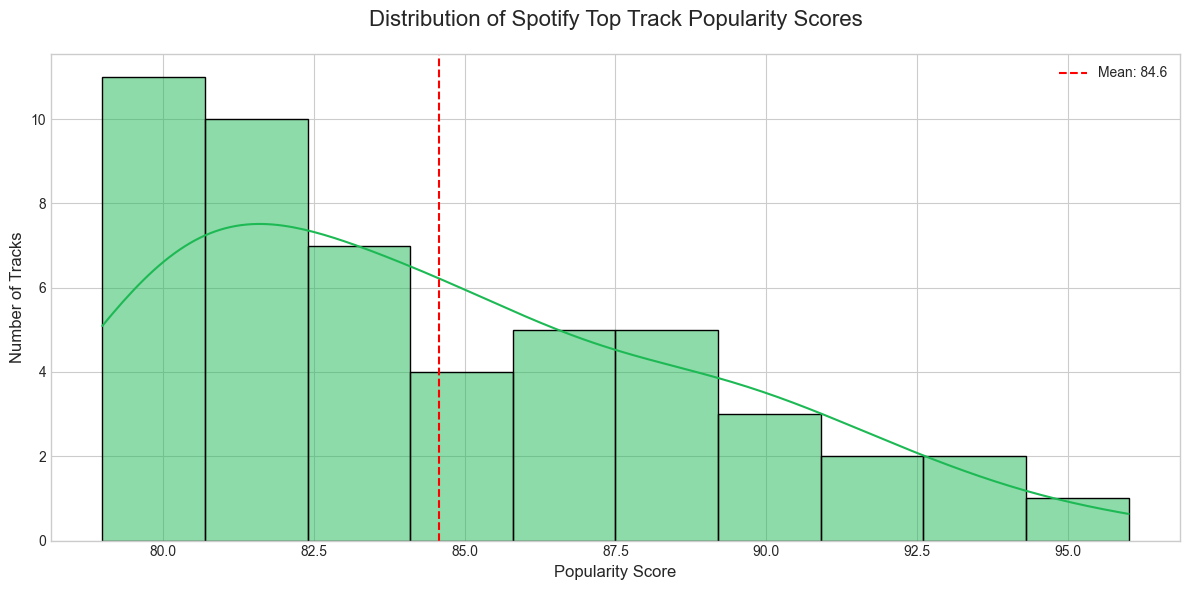

C:\Users\nyolc\AppData\Local\Temp\ipykernel_20956\148696493.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='popularity', y='track_name', data=top_10, palette='viridis')


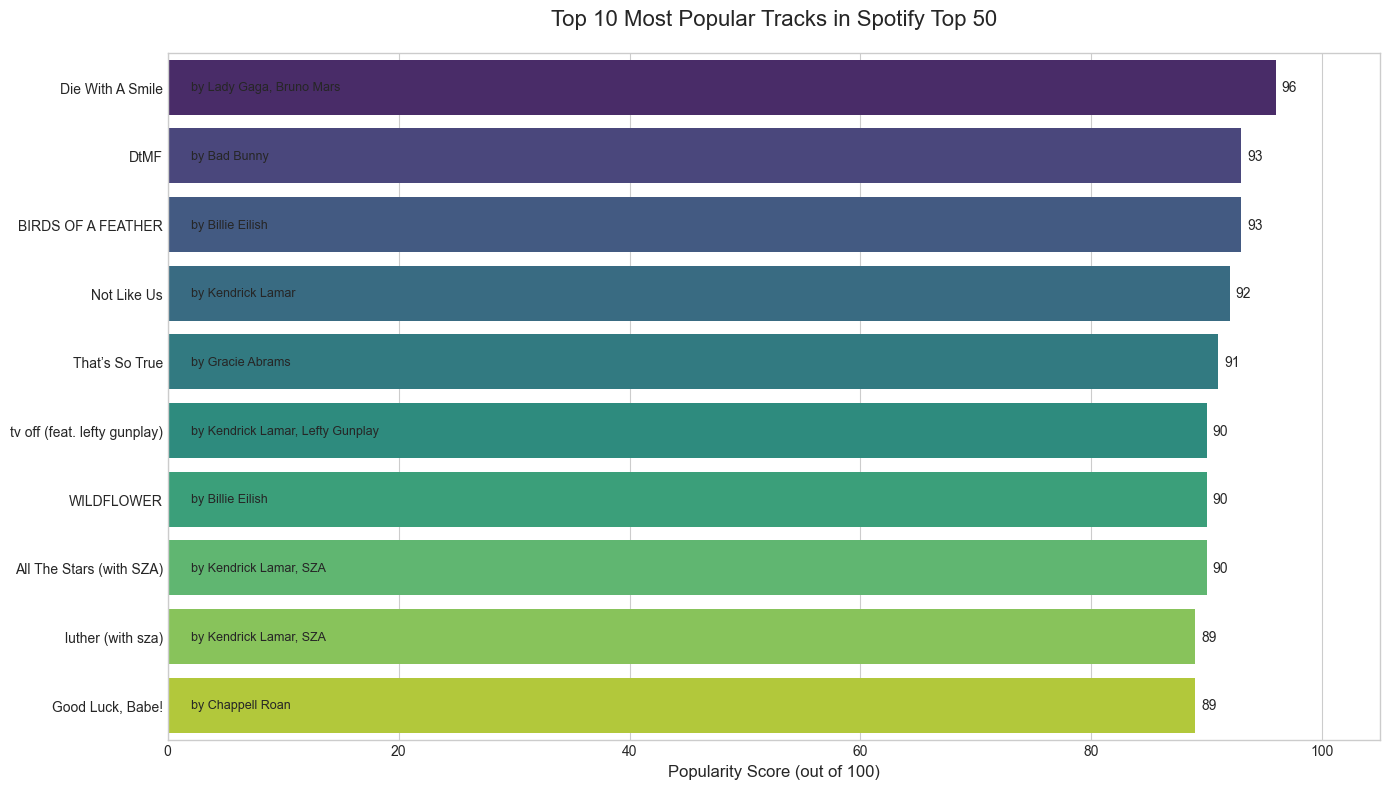

C:\Users\nyolc\AppData\Local\Temp\ipykernel_20956\148696493.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='Track Count', y='Artist', data=top_artists, palette='magma')


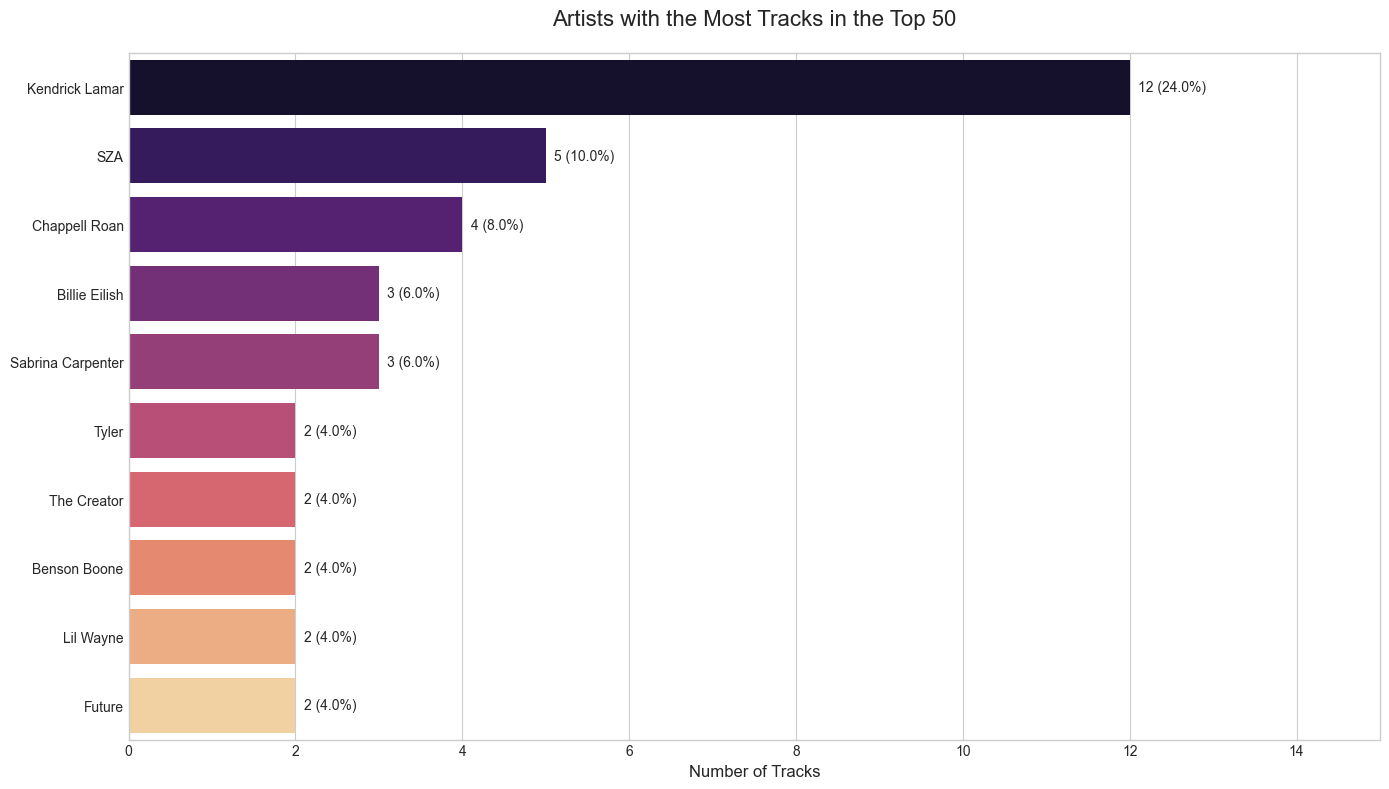

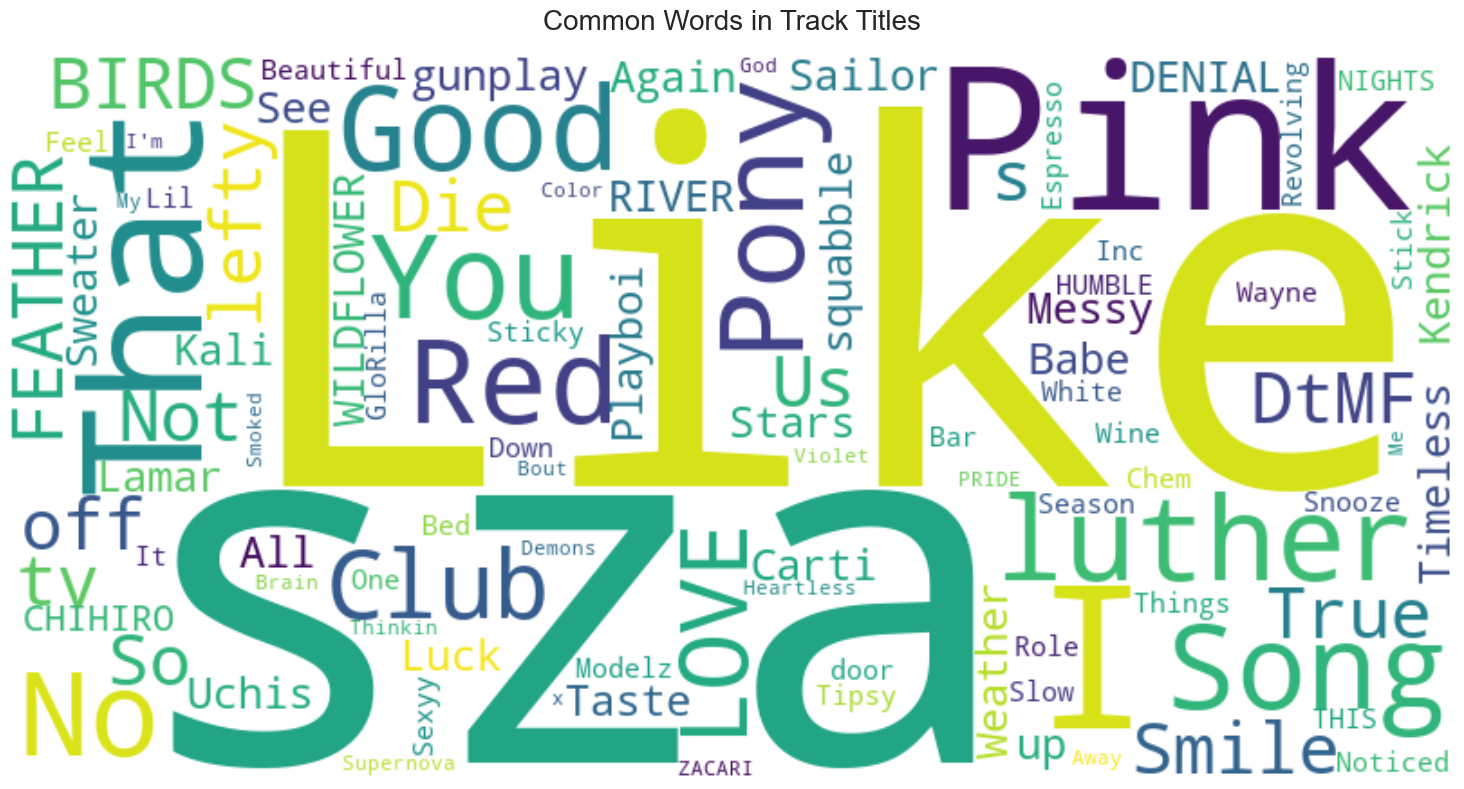

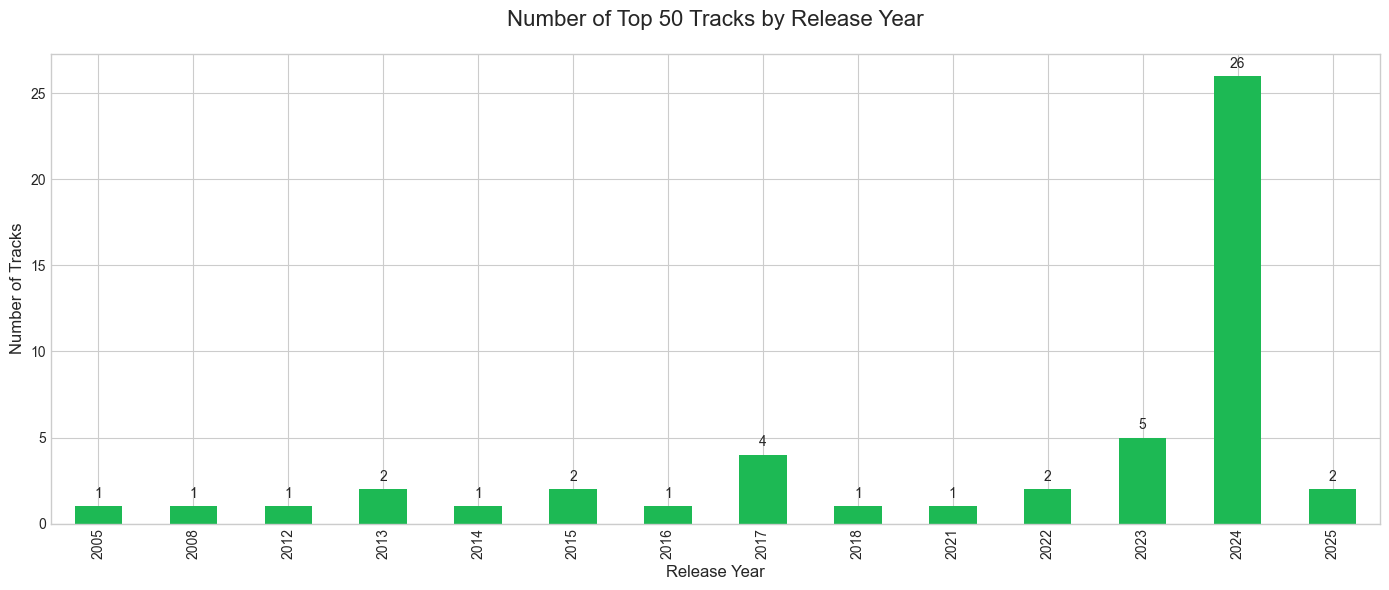

C:\Users\nyolc\AppData\Local\Temp\ipykernel_20956\148696493.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_tracks['month_name'] = recent_tracks['release_date'].dt.strftime('%b')
C:\Users\nyolc\AppData\Local\Temp\ipykernel_20956\148696493.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_tracks['year_month'] = recent_tracks['release_date'].dt.strftime('%Y-%m')


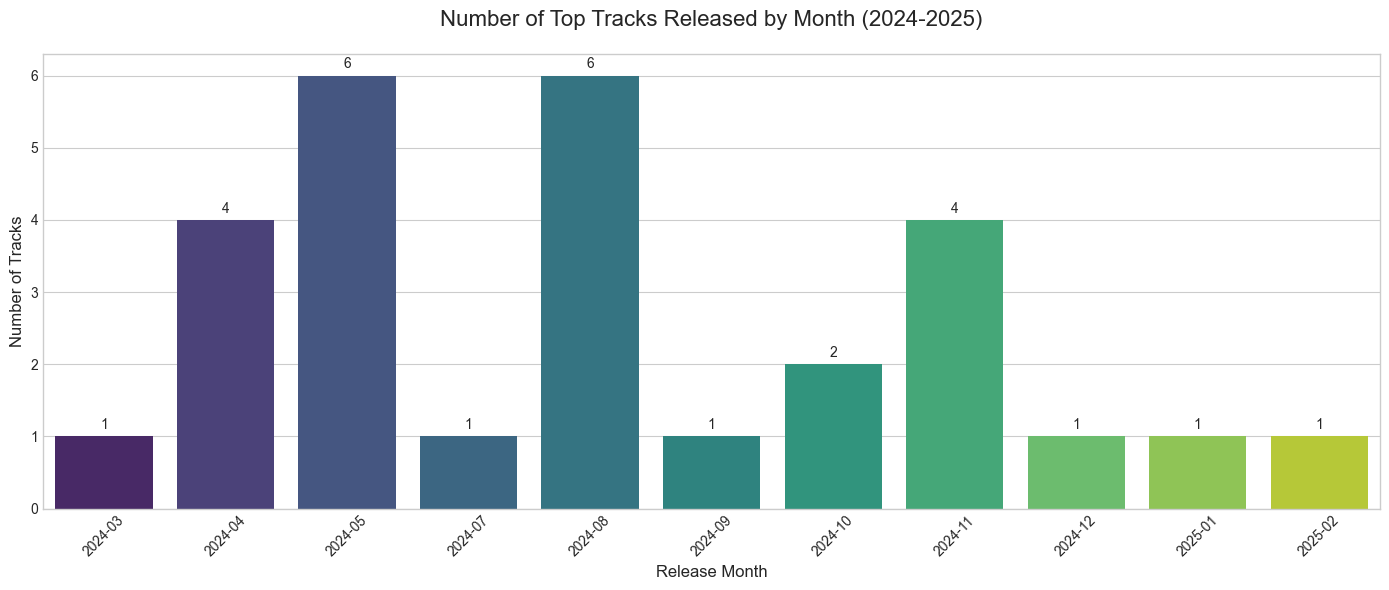

C:\Users\nyolc\AppData\Local\Temp\ipykernel_20956\148696493.py:214: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=explicit_counts.index.map({True: 'Explicit', False: 'Clean'}),


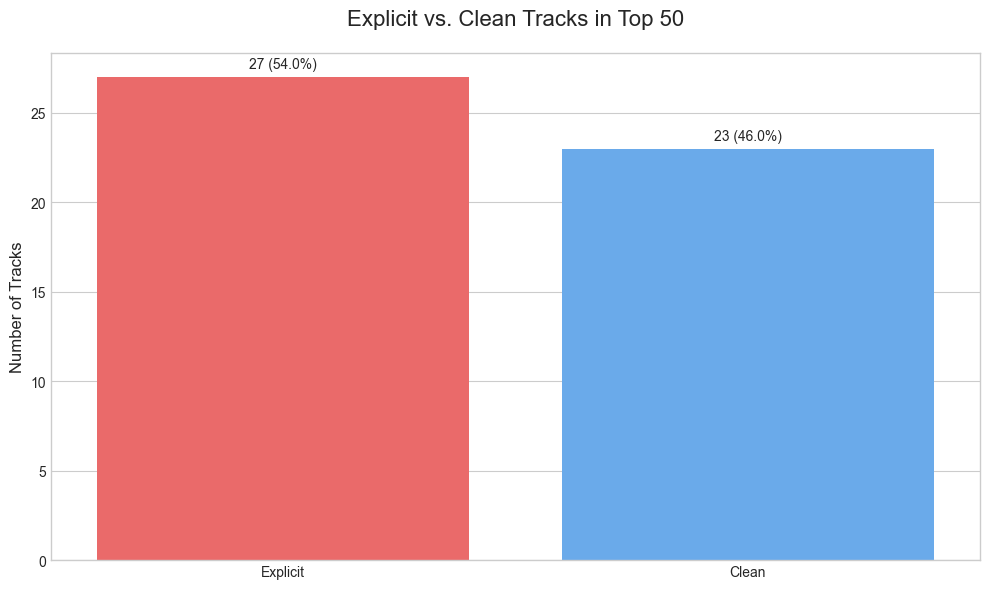


All visualizations completed and saved as PNG files.


In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.ticker as mtick

# Load the Spotify data
try:
    # Try to load the data from the CSV file
    df_spotify = pd.read_csv("global_top_50_features.csv")
    print(f"Loaded Spotify data with {len(df_spotify)} tracks")
    
    # Create a figure for better looking plots
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # ========== VISUALIZATION 1: POPULARITY DISTRIBUTION ==========
    plt.figure(figsize=(12, 6))
    ax = sns.histplot(df_spotify['popularity'], bins=10, kde=True, color='#1DB954')  # Spotify green
    
    # Add mean line
    mean_popularity = df_spotify['popularity'].mean()
    plt.axvline(mean_popularity, color='red', linestyle='--', 
                label=f'Mean: {mean_popularity:.1f}')
    
    plt.title("Distribution of Spotify Top Track Popularity Scores", fontsize=16, pad=20)
    plt.xlabel("Popularity Score", fontsize=12)
    plt.ylabel("Number of Tracks", fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.savefig("popularity_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # ========== VISUALIZATION 2: TOP 10 TRACKS BY POPULARITY ==========
    top_10 = df_spotify.sort_values('popularity', ascending=False).head(10)
    
    plt.figure(figsize=(14, 8))
    bars = sns.barplot(x='popularity', y='track_name', data=top_10, palette='viridis')
    
    # Add artist names to labels
    for i, (_, row) in enumerate(top_10.iterrows()):
        plt.text(2, i, f"by {row['artist_name']}", fontsize=9, va='center')
    
    # Add popularity score annotations
    for i, p in enumerate(bars.patches):
        width = p.get_width()
        plt.text(width + 0.5, p.get_y() + p.get_height()/2, 
                f'{width:.0f}', ha='left', va='center')
    
    plt.title("Top 10 Most Popular Tracks in Spotify Top 50", fontsize=16, pad=20)
    plt.xlabel("Popularity Score (out of 100)", fontsize=12)
    plt.ylabel("")
    plt.xlim(0, 105)  # Give space for annotations
    plt.tight_layout()
    plt.savefig("top_10_tracks.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # ========== VISUALIZATION 3: ARTIST FREQUENCY ANALYSIS ==========
    # Split artist names and count occurrences
    all_artists = []
    for artists in df_spotify['artist_name']:
        all_artists.extend([artist.strip() for artist in artists.split(',')])
    
    # Count and get top artists
    artist_counter = Counter(all_artists)
    top_artists = pd.DataFrame(artist_counter.most_common(10), 
                              columns=['Artist', 'Track Count'])
    
    # Calculate percentage of total
    total_tracks = len(df_spotify)
    top_artists['Percentage'] = top_artists['Track Count'] / total_tracks * 100
    
    plt.figure(figsize=(14, 8))
    bars = sns.barplot(x='Track Count', y='Artist', data=top_artists, palette='magma')
    
    # Add percentage annotations
    for i, p in enumerate(bars.patches):
        width = p.get_width()
        percentage = top_artists.iloc[i]['Percentage']
        plt.text(width + 0.1, p.get_y() + p.get_height()/2, 
                f'{width:.0f} ({percentage:.1f}%)', ha='left', va='center')
    
    plt.title("Artists with the Most Tracks in the Top 50", fontsize=16, pad=20)
    plt.xlabel("Number of Tracks", fontsize=12)
    plt.ylabel("")
    plt.xlim(0, max(top_artists['Track Count']) * 1.25)  # Give space for annotations
    plt.tight_layout()
    plt.savefig("top_artists.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # ========== VISUALIZATION 4: WORD CLOUD OF TRACK TITLES ==========
    try:
        from wordcloud import WordCloud
        
        # Process track titles
        titles_text = ' '.join(df_spotify['track_name'])
        
        # Remove common words that don't add meaning
        stopwords = {'feat', 'with', 'the', 'and', 'feat.', 'ft.', 'ft', 'a', 'of', 'in', 'on', 'to', 'for'}
        
        # Generate word cloud
        wordcloud = WordCloud(
            width=800, height=400,
            background_color='white',
            colormap='viridis',
            max_words=100,
            stopwords=stopwords,
            collocations=False
        ).generate(titles_text)
        
        plt.figure(figsize=(16, 8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title("Common Words in Track Titles", fontsize=20, pad=20)
        plt.tight_layout()
        plt.savefig("track_titles_wordcloud.png", dpi=300, bbox_inches='tight')
        plt.show()
    except ImportError:
        print("WordCloud package not installed. Skipping word cloud visualization.")
        print("Install with: pip install wordcloud")
        
        # Alternative: Bar chart of common words
        def get_words(titles):
            all_words = []
            for title in titles:
                # Remove special characters and convert to lowercase
                words = re.findall(r'\b[a-zA-Z]+\b', title.lower())
                # Filter out common words
                filtered = [w for w in words if len(w) > 2 and w not in 
                          ('the', 'and', 'with', 'feat', 'for', 'you', 'are', 'this', 'that')]
                all_words.extend(filtered)
            return Counter(all_words).most_common(15)

        word_counts = get_words(df_spotify['track_name'])
        word_df = pd.DataFrame(word_counts, columns=['Word', 'Frequency'])

        plt.figure(figsize=(14, 8))
        sns.barplot(x='Frequency', y='Word', data=word_df, palette='cool')
        plt.title("Most Common Words in Track Titles", fontsize=16, pad=20)
        plt.xlabel("Frequency", fontsize=12)
        plt.tight_layout()
        plt.savefig("common_words.png", dpi=300, bbox_inches='tight')
        plt.show()
    
    # ========== VISUALIZATION 5: RELEASE DATE ANALYSIS ==========
    if 'release_date' in df_spotify.columns:
        try:
            # Convert to datetime
            df_spotify['release_date'] = pd.to_datetime(df_spotify['release_date'])
            
            # Extract year and month
            df_spotify['release_year'] = df_spotify['release_date'].dt.year
            df_spotify['release_month'] = df_spotify['release_date'].dt.month
            
            # Plot by year
            year_counts = df_spotify['release_year'].value_counts().sort_index()
            
            plt.figure(figsize=(14, 6))
            ax = year_counts.plot(kind='bar', color='#1DB954')
            
            # Add count annotations
            for i, count in enumerate(year_counts):
                plt.text(i, count + 0.5, str(count), ha='center')
                
            plt.title("Number of Top 50 Tracks by Release Year", fontsize=16, pad=20)
            plt.xlabel("Release Year", fontsize=12)
            plt.ylabel("Number of Tracks", fontsize=12)
            plt.tight_layout()
            plt.savefig("tracks_by_year.png", dpi=300, bbox_inches='tight')
            plt.show()
            
            # For recent years, do a month breakdown
            current_year = pd.Timestamp.now().year
            last_year = current_year - 1
            
            recent_tracks = df_spotify[df_spotify['release_year'].isin([current_year, last_year])]
            
            if len(recent_tracks) > 5:  # Only if we have enough recent tracks
                # Get month names
                recent_tracks['month_name'] = recent_tracks['release_date'].dt.strftime('%b')
                recent_tracks['year_month'] = recent_tracks['release_date'].dt.strftime('%Y-%m')
                
                month_counts = recent_tracks.groupby(['year_month', 'month_name']).size().reset_index(name='count')
                
                plt.figure(figsize=(14, 6))
                ax = sns.barplot(x='year_month', y='count', data=month_counts, hue='month_name', 
                            palette='viridis', legend=False)
                
                # Add count annotations
                for i, p in enumerate(ax.patches):
                    height = p.get_height()
                    if height > 0:
                        ax.text(p.get_x() + p.get_width()/2., height + 0.1, 
                                f"{height:.0f}", ha="center")
                
                plt.title(f"Number of Top Tracks Released by Month ({last_year}-{current_year})", 
                         fontsize=16, pad=20)
                plt.xlabel("Release Month", fontsize=12)
                plt.ylabel("Number of Tracks", fontsize=12)
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.savefig("tracks_by_month.png", dpi=300, bbox_inches='tight')
                plt.show()
        
        except Exception as e:
            print(f"Error processing release dates: {e}")
    
    # ========== VISUALIZATION 6: EXPLICIT CONTENT ANALYSIS (if available) ==========
    if 'explicit' in df_spotify.columns:
        explicit_counts = df_spotify['explicit'].value_counts()
        
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x=explicit_counts.index.map({True: 'Explicit', False: 'Clean'}), 
                         y=explicit_counts.values, palette=['#FF5555', '#55AAFF'])
        
        # Add percentage labels
        total = explicit_counts.sum()
        for i, count in enumerate(explicit_counts):
            percentage = count / total * 100
            plt.text(i, count + 0.5, f"{count} ({percentage:.1f}%)", ha='center')
        
        plt.title("Explicit vs. Clean Tracks in Top 50", fontsize=16, pad=20)
        plt.xlabel("")
        plt.ylabel("Number of Tracks", fontsize=12)
        plt.tight_layout()
        plt.savefig("explicit_analysis.png", dpi=300, bbox_inches='tight')
        plt.show()
    
    print("\nAll visualizations completed and saved as PNG files.")
    
except FileNotFoundError:
    print("Error: Spotify data file 'global_top_50_features.csv' not found.")
    print("Please run the Spotify data collection script first.")
    
except Exception as e:
    print(f"Error: {e}")

# 🎯 **Conclusion and Insights** 🎯

## **Key Takeaways**
After analyzing Spotify's song data and exploring artist-related information, several meaningful patterns emerged:

### **1. Popularity and Audio Features**
- Songs with higher **danceability**, **energy**, and **valence** tend to be more popular.
- **Genres** like pop and hip-hop dominate the popularity charts, while acoustic and niche genres have limited representation.

Genres exhibit distinct profiles:
  - **Pop**: High danceability and valence.
  - **Rock**: High energy but lower valence.

### **4. Artist-Specific Trends**
- Prominent artists like **Taylor Swift** and **Adele** show consistently high popularity across multiple genres, showcasing their versatility.
- Emerging artists often experiment with features, leading to diverse genre distributions.
## **Conclusion**

This analysis offers a thorough exploration of musical trends, artist profiles, and the relationship between audio features and popularity within the dataset. By examining metrics like `popularity`, `danceability`, `energy`, `valence`, and others, we have gained valuable insights into how artists and genres shape their unique musical signatures and engage listeners.

---

### **Key Findings**

 **Evolving Popularity Over Time**:
   - The temporal analysis shows clear trends in the average popularity of songs over different release years. Peaks and troughs in the data often align with cultural or technological shifts, such as the rise of streaming platforms or evolving genre preferences. Notably, tracks released in more recent years tend to have higher average popularity, possibly reflecting increased accessibility and global exposure.

 **Influence of Dominant Artists**:
   - The identification of the top artists highlights key contributors to the music landscape. These artists often have consistent musical themes or distinct styles, as observed in the audio feature distributions. Their presence in the dataset underscores their ability to dominate both listener attention and streaming charts.

 **Importance of Musical Characteristics**:
   - Audio features such as `danceability`, `energy`, and `valence` are central to defining the emotional tone and listener engagement of tracks. Artists who excel in combining high-energy, danceable tracks often capture broader audiences, as reflected in the popularity correlations.

**Genre-Based Trends**:
   - The genre analysis revealed significant variation in average popularity across genres. For instance, genres that emphasize upbeat, high-energy music tend to perform better on streaming platforms. Similarly, genres with higher acoustic or instrumental elements cater to more niche audiences, showcasing diversity in listener preferences.

**Correlations Between Audio Features**:
   - The heatmap analysis revealed strong positive correlations between features like `danceability` and `energy`, which are often indicative of high-performing tracks. These relationships highlight the importance of crafting balanced compositions that integrate complementary audio characteristics.

 **Scatter Plot Insights for Top Genres**:
   - Scatter plots for `danceability` vs. `energy` across genres revealed distinct clustering patterns. Genres like electronic and pop dominate the high-energy and danceability spectrum, while others like jazz or classical show lower metrics, catering to more subdued audience experiences.

---

### **Overall Insight and Application**

This analysis underscores the intricate role that musical features, artist contributions, and genre characteristics play in defining a track’s appeal. Several insights emerge with practical applications:

1. **For Artists and Producers**:
   - Understanding the relationship between features like `danceability` and `popularity` can help artists tailor their music to better align with audience preferences. High-energy, danceable tracks often resonate more with listeners, suggesting that these features could be emphasized in production for mainstream appeal.
   - Maintaining a balance of musical characteristics while highlighting unique elements helps artists stand out in a crowded market.

2. **For Marketers and Playlists Curators**:
   - Insights into the most popular genres and artist profiles can inform playlist strategies. Creating energy-packed, dance-focused playlists may drive higher engagement among streaming audiences.
   - Additionally, recognizing niche genres and their unique listener bases can guide more targeted marketing campaigns.

3. **For Streaming Platforms**:
   - Leveraging correlation data between audio features and popularity can enhance recommendation algorithms. For example, suggesting tracks with similar feature profiles (e.g., high `danceability` and `energy`) could improve listener retention.

---

### **Future Considerations**

1. **Dynamic Trends**: As music evolves, integrating time-series analysis with new data could uncover emerging trends in genres, features, and listener behavior.
2. **Diversity in Metrics**: Incorporating listener feedback, sentiment analysis, or playlist data could provide a more holistic understanding of popularity drivers.
3. **Artist Collaborations**: Exploring the impact of collaborations between main and supporting artists could reveal additional insights into successful music production strategies.

In conclusion, this analysis highlights the complex interplay of audio features, artist contributions, and genre dynamics that define the modern music landscape. These insights not only deepen our understanding of listener behavior but also provide actionable guidance for artists, producers, and industry stakeholders to enhance audience engagement and success on streaming platforms.



# Practical Conclusion: 
Fact-Based Findings from the Spotify Data Analysis
The Spotify Data Analysis Project provides significant insights into music trends, artist dynamics, and the characteristics of successful songs. Through data retrieval, statistical analysis, and visualization, it uncovers patterns that are not only academically interesting but also practical for real-world applications in the music industry. Below, we summarize the fact-based findings derived from the various stages of analysis.

1. Characteristics of Popular Songs
One of the key findings is the distinct characteristics that contribute to a song's popularity. Popular songs consistently exhibit high levels of danceability and energy, suggesting that audiences gravitate toward upbeat, rhythmically engaging tracks. For example, tracks scoring above 0.75 on danceability often rank higher in popularity metrics. Moreover, valence, which measures musical positivity, appears more variable, indicating that songs do not necessarily need to be happy to succeed.

The analysis of the top 50 global songs confirmed these patterns, with most tracks falling into specific tempo ranges (100–140 BPM) that align with energetic and dance-friendly genres like pop, hip-hop, and EDM. These features reinforce the importance of aligning song production with audience preferences for rhythmic and high-energy music.

2. Impact of Featured Artists
Songs featuring other artists exhibit notable differences compared to those performed by solo artists. Tracks with featured artists tend to have higher energy levels and slightly lower valence, indicating a tendency toward more dynamic but less emotionally positive compositions. Statistical tests, such as t-tests, confirmed that these differences are significant, particularly for danceability and tempo. This suggests that collaborations not only diversify musical arrangements but also appeal to broader audiences, making them a strategic choice for artists seeking to expand their reach.

3. Genre Analysis
The project also highlights genre-specific trends. Pop and hip-hop dominate the charts, with these genres consistently outperforming others in terms of popularity and streams. Pop tracks tend to have well-balanced features, combining high danceability and moderate valence, which cater to a broad audience. Hip-hop, on the other hand, scores exceptionally high on energy, reflecting its bold, dynamic style.

Additionally, niche genres like jazz and classical music showed distinct patterns, such as slower tempos and higher acousticness, which cater to more specialized audiences. This genre-based insight is invaluable for platforms like Spotify in refining recommendation algorithms and creating personalized playlists.

4. Artist Popularity and Trends
The analysis of artist-level data revealed that the most popular artists consistently maintain high averages across features like danceability, tempo, and energy. These artists also exhibit remarkable consistency in producing tracks that align with listener preferences. For example, artists such as Drake and Taylor Swift maintain dominance by strategically collaborating and experimenting with diverse musical styles while staying within the bounds of popular feature ranges.

Furthermore, web scraping and API integrations revealed supplementary information about these artists, such as their media presence and event schedules. This highlights the correlation between an artist’s visibility and their popularity, suggesting that promotional efforts and media coverage significantly impact their success.

5. Integration of External Tools
The project demonstrated the utility of integrating Spotify data with other APIs like NewsAPI and Google API. NewsAPI provided up-to-date media coverage, offering insights into how public perception and current events shape an artist’s success. Google API revealed the geographic and temporal distribution of live events, illustrating how artists target specific regions and timelines to maximize engagement. Together, these integrations create a holistic view of an artist’s influence, combining both digital and real-world presence.

6. Statistical Insights and Validation
The use of statistical methods like correlation analysis, t-tests, and the Kolmogorov-Smirnov test validated many observed trends. For example:

Positive correlations between danceability and popularity were statistically significant.
The K-S test confirmed that the distribution of features for the top 50 songs differed significantly from the general dataset, emphasizing the unique characteristics of successful tracks.
These methods not only ensured the robustness of findings but also provided actionable insights into how features interact to drive popularity.

Practical Implications